In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import numpy as np
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import pickle

In [22]:
plt.style.use('seaborn-poster')

In [5]:
MNM_nb_folder = os.path.join('..', '..', '..', 'side_project', 'network_builder')
sys.path.append(MNM_nb_folder)
python_lib_folder = os.path.join('..', '..', 'pylib')
sys.path.append(python_lib_folder)

In [6]:
from MNM_nb import *
import MNMAPI
from sDODE import *

In [7]:
data_folder = os.path.join('..', '..', '..', 'data', 'input_files_31net')

In [8]:
nb = MNM_network_builder()
nb.load_from_folder(data_folder)
O_dist = np.arange(3)
D_dist = np.arange(1)
usefuk_link_list = list(filter(lambda x: x.typ == 'CTM', nb.link_list))

MNM_config
MNM_pathtable


In [9]:
len(usefuk_link_list)

24

In [10]:
num_observed_links = 12

In [11]:
config = dict()

config['use_link_flow'] = True
config['use_link_tt'] = False
config['link_flow_weight'] = 1
config['link_tt_weight'] = 1
config['num_data'] = 100
config['observed_links'] = list(map(lambda x: x.ID, np.random.choice(usefuk_link_list, num_observed_links)))
config['paths_list'] = list(range(nb.config.config_dict['FIXED']['num_path']))

In [12]:
num_interval = nb.config.config_dict['DTA']['max_interval']
theta = 0.01

In [13]:
sdode = SDODE(nb, config)
# true_q = sdode.init_demand_flow(init_scale = 50)
# true_q_para = OD_parameter_server(sdode.demand_list, sdode.num_assign_interval)
# true_q_para.construct(O_dist, D_dist)
# true_q_para.initialize(mean_scale = 50, std_scale= 10, 
#                         O_cov_scale = 5, D_cov_scale = 5)
true_q_para = pickle.load(open('potential_true_q_312.pickle', 'rb'))
true_q = np.concatenate(true_q_para.demand_mean_list)
old_f = np.zeros(num_interval * len(config['paths_list']))
num_iters = 50
P = sdode.nb.get_route_portion_matrix()
true_f = P.dot(true_q)
for i in range(num_iters):
    dta = sdode._run_simulation(true_f)
    path_cost = dta.get_path_tt(np.arange(0, sdode.num_loading_interval, sdode.ass_freq))
    sdode.assign_route_portions(path_cost, theta = theta)
    new_f = sdode.nb.get_route_portion_matrix().dot(true_q)
    true_f = np.float(i) / np.float(i+1) * true_f + np.float(1) / np.float(i+1) * new_f
#     print np.linalg.norm(true_f - old_f)
    old_f = true_f
    sdode.nb.update_demand_path(new_f)

In [14]:
assert (np.isclose(true_q.sum(), true_f.sum()))

In [15]:
dta = sdode._run_simulation(true_f)
true_P = sdode.nb.get_route_portion_matrix()
true_full_dar = sdode.get_full_dar(dta, true_f)
true_dar = true_full_dar[sdode.get_full_observed_link_index(),:]
full_true_x = true_full_dar.dot(true_f)
true_x = true_dar.dot(true_f)
true_path_cost = dta.get_path_tt(np.arange(0, sdode.num_loading_interval, sdode.ass_freq))

In [16]:
num_data = config['num_data']
data_dict = dict()
data_dict['link_flow'] = list()
sdode = SDODE(nb, config)
for i in range(config['num_data']):
    q_e, _ = true_q_para.forward()
    f_e = true_P.dot(q_e)
    dta = sdode._run_simulation(f_e)
    full_dar_e = sdode.get_full_dar(dta, f_e)
    dar_e = full_dar_e[sdode.get_full_observed_link_index(),:]
    x_e = dar_e.dot(f_e)
    link_df = pd.DataFrame(index = range(num_interval), columns = config['observed_links'], 
                           data = x_e.reshape((num_interval, len(config['observed_links']))) 
                               + np.random.randn(num_interval, len(config['observed_links'])) * np.sqrt(5))
    data_dict['link_flow'].append(link_df)

In [17]:
sdode.add_data(data_dict)

In [18]:
print "Start sovling"
q_para, loss_list1 = sdode.estimate_demand_cov(O_dist, D_dist, init_mean_scale = 1, 
                      init_std_scale = 0.1, init_O_cov_scale = 0.1,
                      init_D_cov_scale = 0.1, step_size = 1, theta = theta, max_epoch = 60,
                                  adagrad = True, known_path_cost = None)

Start sovling
Epoch: 0 Loss: 100.67390042704955
Epoch: 1 Loss: 68.15574225143722
Epoch: 2 Loss: 55.59727642374557
Epoch: 3 Loss: 47.70552172314156
Epoch: 4 Loss: 43.31575946781126
Epoch: 5 Loss: 40.76226150090221
Epoch: 6 Loss: 38.874060782058564
Epoch: 7 Loss: 36.65089723295792
Epoch: 8 Loss: 36.777577287433644
Epoch: 9 Loss: 35.83581981146696
Epoch: 10 Loss: 34.976430000015775
Epoch: 11 Loss: 34.753426069268855
Epoch: 12 Loss: 34.41044128228304
Epoch: 13 Loss: 33.15064011774919
Epoch: 14 Loss: 33.676483529580224
Epoch: 15 Loss: 33.007677589813056
Epoch: 16 Loss: 32.9608005202479
Epoch: 17 Loss: 33.33152470444318
Epoch: 18 Loss: 33.054088080712404
Epoch: 19 Loss: 33.20402196729682
Epoch: 20 Loss: 32.625718030364396
Epoch: 21 Loss: 33.07858189227679
Epoch: 22 Loss: 32.89814261772733
Epoch: 23 Loss: 32.47819605597069
Epoch: 24 Loss: 32.81578695892427
Epoch: 25 Loss: 32.732675099062874
Epoch: 26 Loss: 33.09051526312442
Epoch: 27 Loss: 32.95151999179747
Epoch: 28 Loss: 32.490681696804764


In [19]:
q_para.demand_std_list

[array([0.28951632, 0.35491004, 0.05257454]),
 array([0.13221167, 0.03404178, 0.15857636]),
 array([0.21042544, 0.12439922, 0.11471544]),
 array([0.12309545, 0.06748652, 0.00941053]),
 array([0.11266834, 0.02247342, 0.27237056]),
 array([0.01365578, 0.04568887, 0.99970975]),
 array([0.20449758, 0.07772156, 0.2033574 ]),
 array([0.0307854 , 0.35951933, 0.28672811]),
 array([0.0629186 , 0.09623322, 0.01012963]),
 array([0.17755908, 0.08510572, 0.01758307])]

In [20]:
true_q_para.demand_std_list

[array([4.17393147, 4.33626907, 2.52351644]),
 array([0.53855779, 0.52498291, 0.49967131]),
 array([2.60930248, 0.22397638, 1.86537175]),
 array([2.01406885, 1.27383945, 0.35383762]),
 array([4.37544175, 4.91796955, 1.33913512]),
 array([1.1415617 , 0.44734318, 4.26798518]),
 array([2.90221349, 0.80537677, 3.02228111]),
 array([2.95714078, 4.80016482, 4.27250801]),
 array([1.56567831, 3.6184584 , 2.6960989 ]),
 array([3.01736766, 2.59438948, 0.02453069])]

In [22]:
list(map(lambda x: x.std_2parts, q_para.O_cov_list))

[array([0.00624403, 0.06502103, 0.01025124, 0.04538286, 0.00747677]),
 array([0.0032691 , 0.08661019, 0.01257347, 0.01721335, 0.04448984]),
 array([0.09578097, 0.03999332, 0.19905523, 0.02222812, 0.01910625]),
 array([0.09082799, 0.13039217, 0.24234456, 0.10983643, 0.02844799]),
 array([0.07772868, 0.12316492, 0.2584121 , 0.04194058, 0.01060885]),
 array([0.13760075, 0.36702459, 0.02476842, 0.08175967, 0.03908076]),
 array([0.07682988, 0.04602666, 0.18293062, 0.19288259, 0.01422635]),
 array([0.04312203, 0.26315345, 0.20022005, 0.05452288, 0.00469418]),
 array([0.0180818 , 0.14209564, 0.02878404, 0.05140673, 0.16165136]),
 array([0.02649655, 0.03527419, 0.02505483, 0.03482304, 0.02009309])]

In [23]:
np.linalg.det(q_para.O_cov_list[0].get_cov().toarray())

6.999580505417652e-05

In [24]:
np.linalg.det(true_q_para.O_cov_list[0].get_cov().toarray())

2.2939304127780256e-05

In [25]:
list(map(lambda x: x.std_2parts, true_q_para.O_cov_list))

[array([0.00912798, 0.01120852, 0.03975996, 0.01640706, 0.00450365]),
 array([0.10133031, 0.03684466, 0.05759694, 0.12085897, 0.00820763]),
 array([0.16593057, 0.01742095, 0.00317589, 0.1975465 , 0.06757851]),
 array([0.20749797, 0.31526248, 0.01853831, 0.06213047, 0.08651751]),
 array([0.03107498, 0.07169294, 0.29630433, 0.05055855, 0.13349915]),
 array([0.19190787, 0.2992336 , 0.00930312, 0.04560457, 0.20325205]),
 array([0.02751078, 0.18283642, 0.20414991, 0.03445862, 0.05445041]),
 array([0.09536209, 0.0436652 , 0.0566222 , 0.14467451, 0.10170017]),
 array([0.13099652, 0.62967271, 0.14564639, 0.22910049, 0.00753378]),
 array([0.06108381, 0.03692517, 0.01752805, 0.03000828, 0.01236845])]

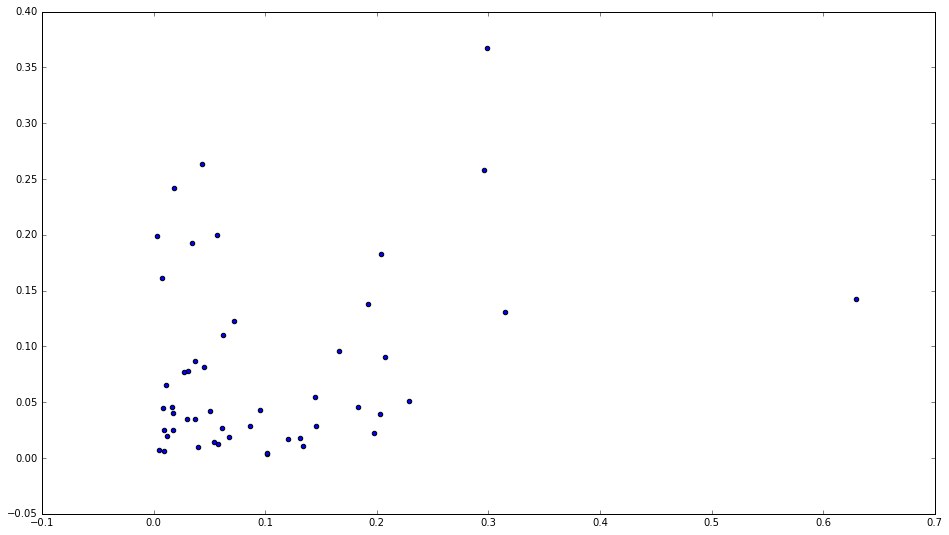

In [26]:
plt.figure(figsize = (16,9))
plt.scatter(np.concatenate(list(map(lambda x: x.std_2parts, true_q_para.O_cov_list))), np.concatenate(list(map(lambda x: x.std_2parts, q_para.O_cov_list))))
plt.show()

In [65]:
q_para.demand_std_list

[array([5.75462829e-02, 1.00000000e-06, 4.16021513e-02]),
 array([0.15175356, 0.12120299, 0.15611982]),
 array([0.02492744, 0.00216707, 0.05957832]),
 array([0.04096077, 0.17615974, 0.01285568]),
 array([0.0239372 , 0.17464319, 0.05660385]),
 array([1.21028103e-01, 1.00000000e-06, 1.00000000e-06]),
 array([0.12179361, 0.0469398 , 0.04315389]),
 array([0.0705121 , 0.13895844, 0.04324499]),
 array([0.19306163, 0.10983797, 0.21968289]),
 array([0.15067355, 0.07437602, 0.09654703])]

In [66]:
true_q_para.demand_std_list

[array([0.28951632, 0.35491004, 0.05257454]),
 array([0.13221167, 0.03404178, 0.15857636]),
 array([0.21042544, 0.12439922, 0.11471544]),
 array([0.12309545, 0.06748652, 0.00941053]),
 array([0.11266834, 0.02247342, 0.27237056]),
 array([0.01365578, 0.04568887, 0.99970975]),
 array([0.20449758, 0.07772156, 0.2033574 ]),
 array([0.0307854 , 0.35951933, 0.28672811]),
 array([0.0629186 , 0.09623322, 0.01012963]),
 array([0.17755908, 0.08510572, 0.01758307])]

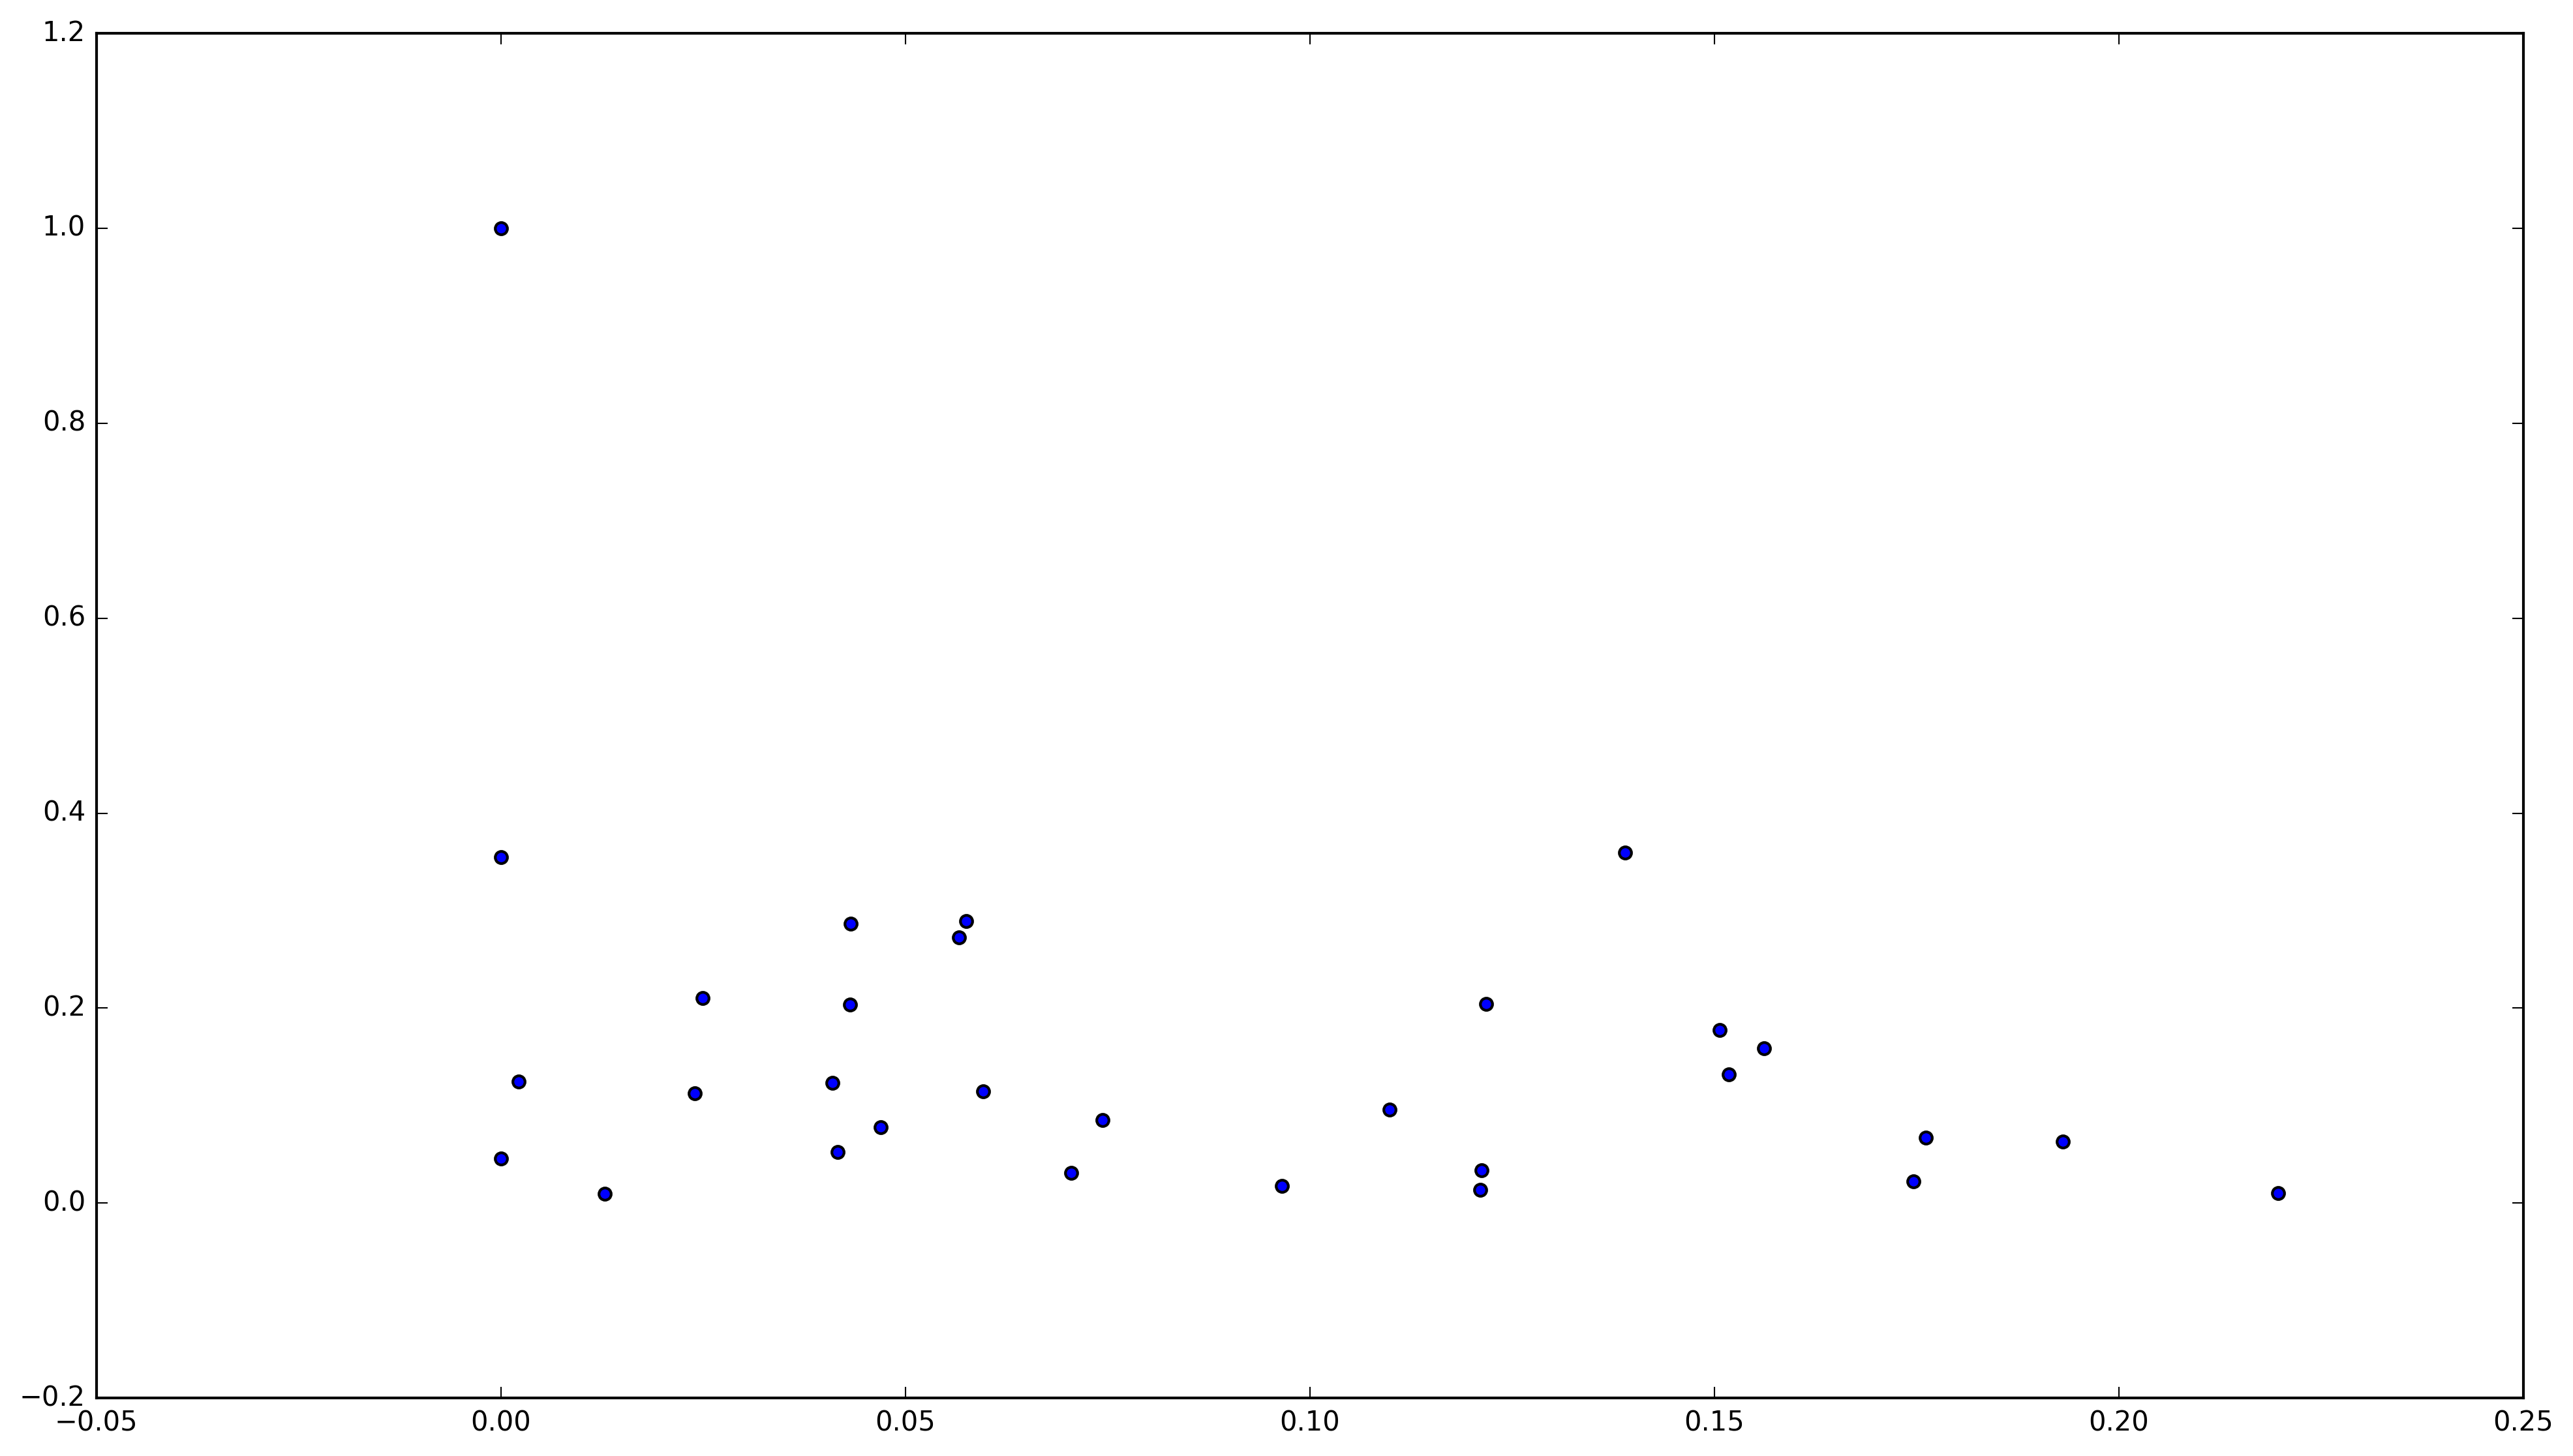

In [36]:
plt.figure(figsize = (16,9), dpi = 300)
plt.scatter(np.concatenate(q_para.demand_std_list), np.concatenate(true_q_para.demand_std_list))
plt.show()

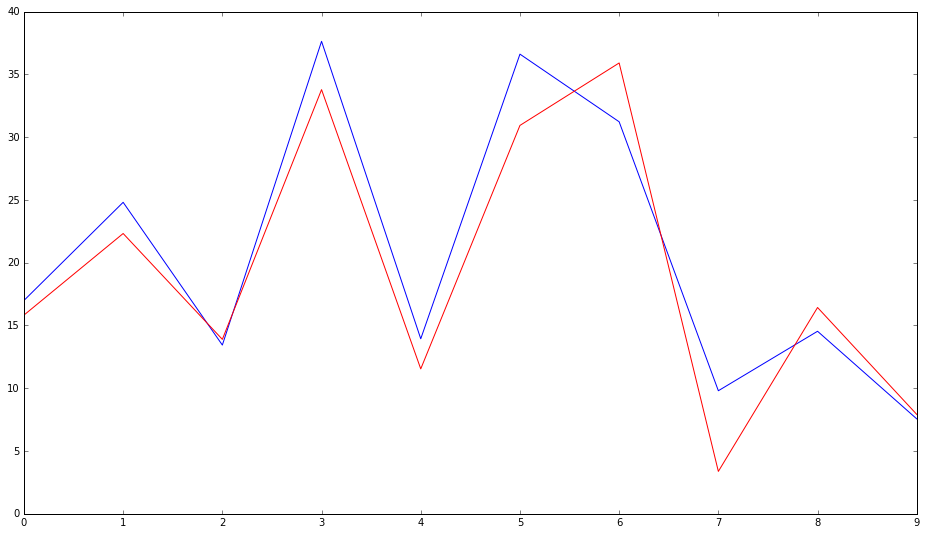

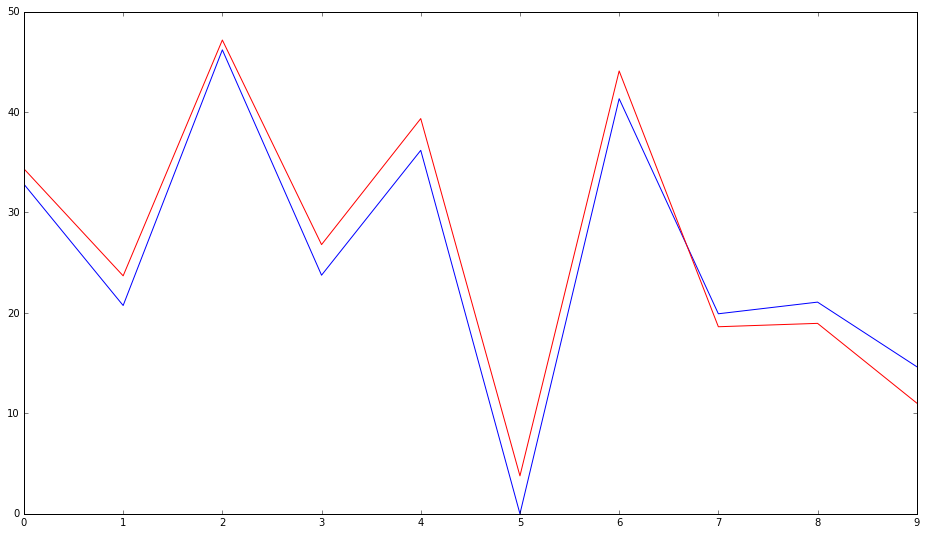

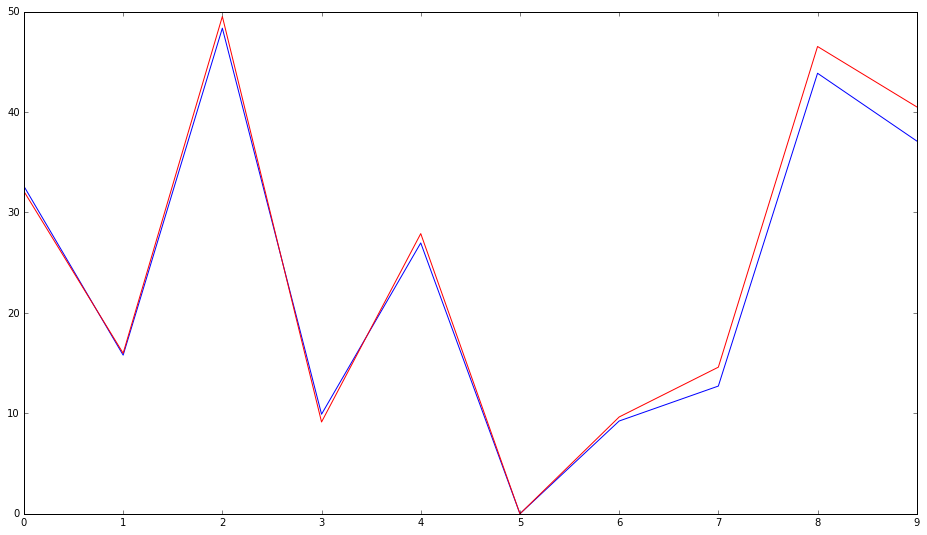

In [51]:
for i in range(3):
    plt.figure(figsize = (16,9))
    plt.plot(np.concatenate(q_para.demand_mean_list).reshape(-1, 3)[:, i])
    plt.plot(np.concatenate(true_q_para.demand_mean_list).reshape(-1, 3)[:, i], color = 'red')
    plt.show()

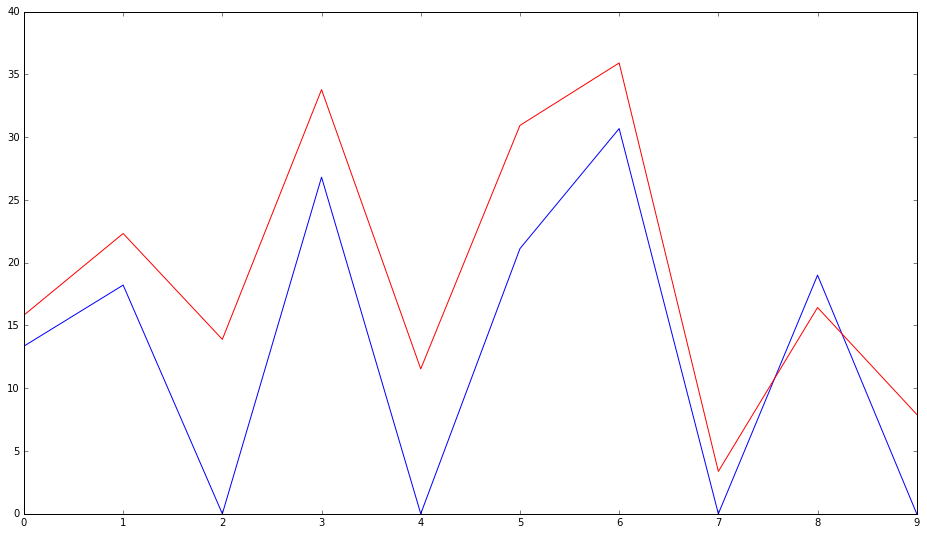

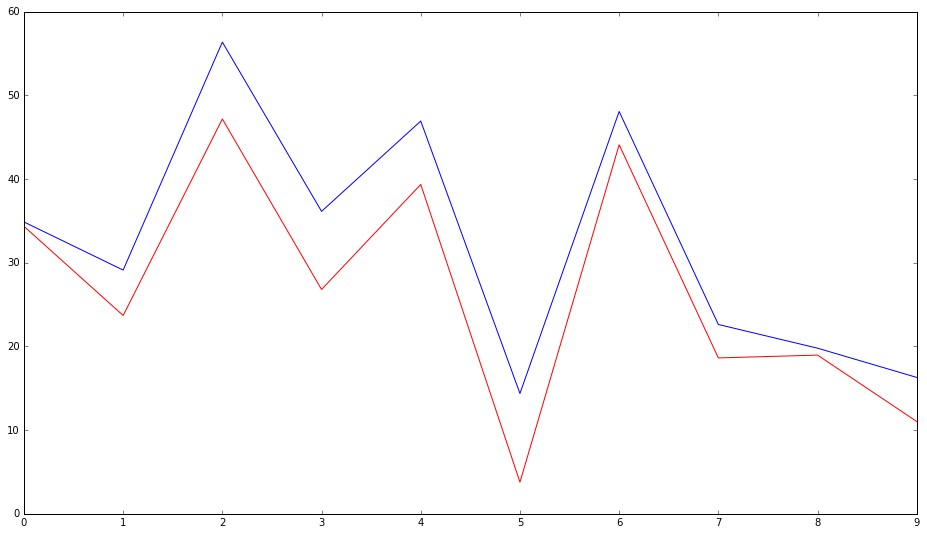

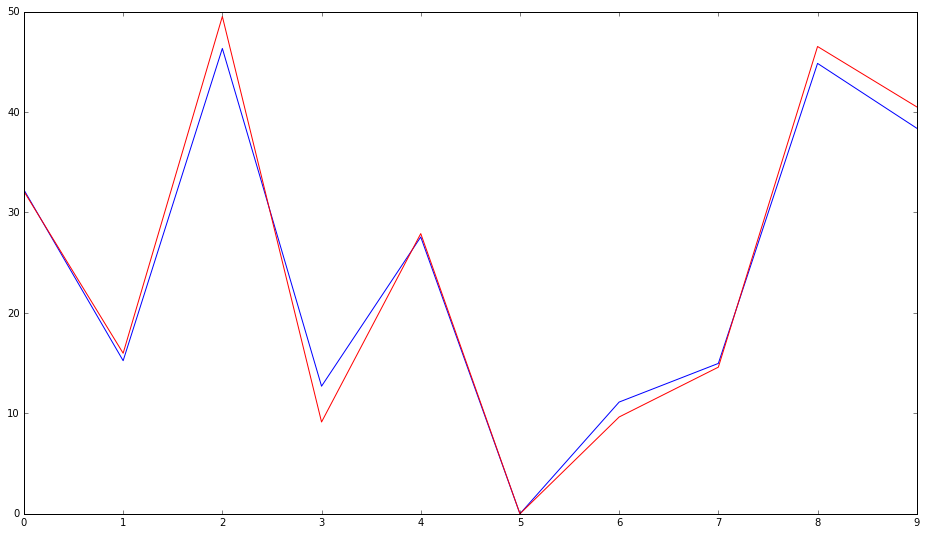

In [52]:
for i in range(3):
    plt.figure(figsize = (16,9))
    plt.plot(q_e.reshape(-1, 3)[:, i])
    plt.plot(np.concatenate(true_q_para.demand_mean_list).reshape(-1, 3)[:, i], color = 'red')
    plt.show()

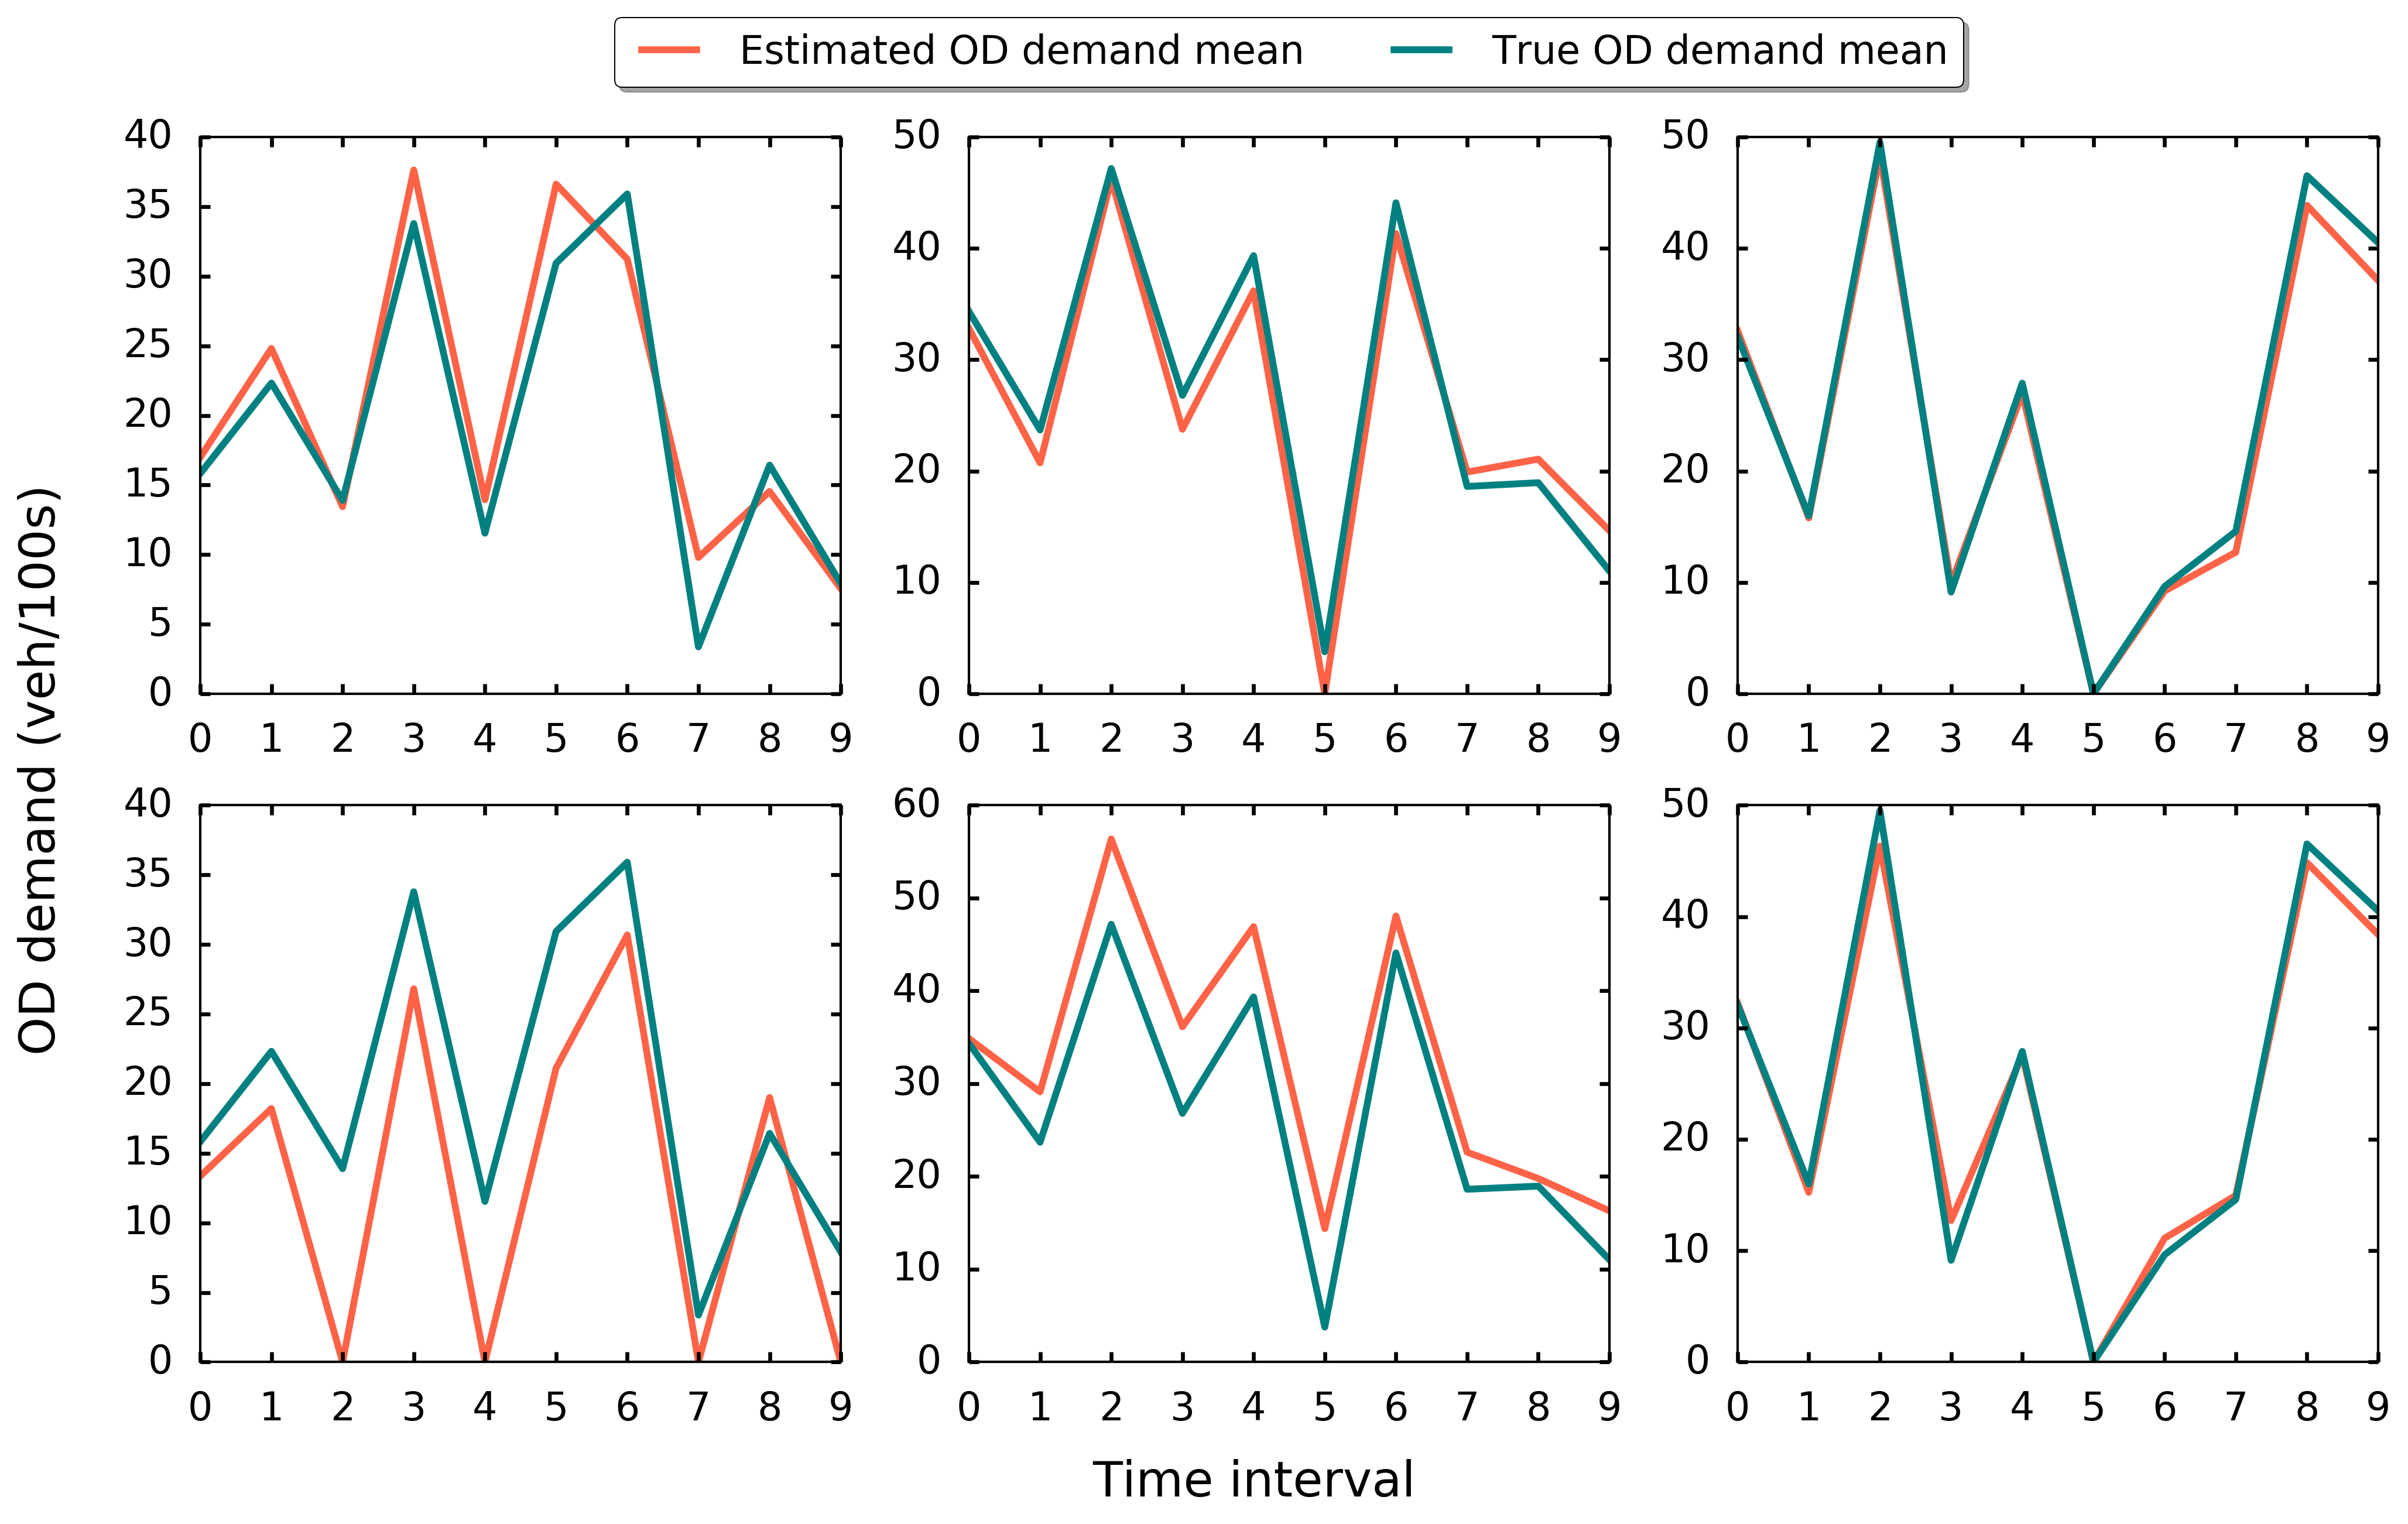

In [87]:
fig, axes = plt.subplots(2,3,  figsize=(16, 9), dpi=300)
for i in range(3):
    axes[0][i].plot(np.concatenate(q_para.demand_mean_list).reshape(-1, 3)[:, i], color = 'tomato', label = 'Estimated OD demand mean')
    axes[0][i].plot(np.concatenate(true_q_para.demand_mean_list).reshape(-1, 3)[:, i], color = 'teal', label = 'True OD demand mean')
for i in range(3):
    axes[1][i].plot(q_e.reshape(-1, 3)[:, i], color = 'tomato', label = 'Estimated OD demand mean')
    axes[1][i].plot(np.concatenate(true_q_para.demand_mean_list).reshape(-1, 3)[:, i], color = 'teal', label = 'True OD demand mean')

fig.text(0.5, 0.04, 'Time interval', ha='center', fontsize = 20)
fig.text(0.06, 0.5, 'OD demand (veh/100s)', va='center', rotation='vertical', fontsize = 20)
axes[0][1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, fancybox=True, shadow=True)
# plt.legend()
plt.show()

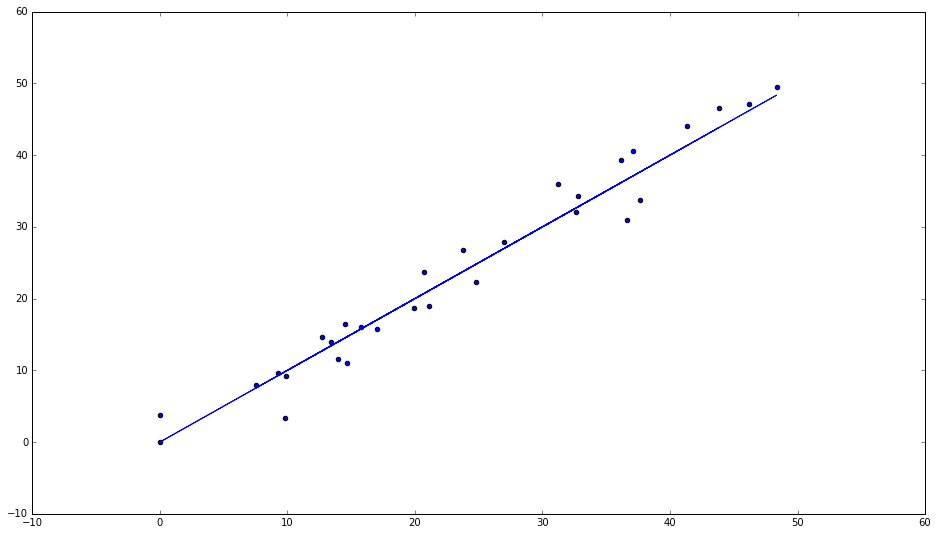

In [60]:
plt.figure(figsize = (16,9))
plt.scatter(np.concatenate(q_para.demand_mean_list), np.concatenate(true_q_para.demand_mean_list))
plt.plot(np.concatenate(q_para.demand_mean_list),np.concatenate(q_para.demand_mean_list))
plt.show()

In [39]:
# pickle.dump(q_para, open('potential_true_q_312.pickle', 'wb'))

In [67]:
# pickle.dump([true_q_para, q_para, q_e, loss_list1, loss_list2,
#                 data_dict, ], open('potential_true_q_31new_result.pickle', 'wb'))

In [35]:
[true_q_para, q_para, q_e, loss_list1, loss_list2,
                data_dict, ] = pickle.load(open('potential_true_q_31new_result.pickle', 'rb'))

In [38]:
q_ee = np.concatenate(q_para.demand_mean_list)
P_ee = sdode.nb.get_route_portion_matrix()
f_ee = true_P.dot(q_ee)
dta = sdode._run_simulation(f_ee)
full_dar_ee = sdode.get_full_dar(dta, f_ee)
dar_ee = full_dar_ee[sdode.get_full_observed_link_index(),:]
x_ee = dar_ee.dot(f_ee)
full_x_ee = full_dar_ee.dot(f_ee)

In [20]:
print "Start sovling"
q_e, loss_list2 = sdode.estimate_demand(init_scale = 0.1, step_size = 1, 
                      max_epoch = 60, adagrad = True,
                      theta = theta)

Start sovling
Epoch: 0 Loss: 130.7910197739572
Epoch: 1 Loss: 66.57149996863977
Epoch: 2 Loss: 40.62041351637713
Epoch: 3 Loss: 35.23952984957672
Epoch: 4 Loss: 34.13404740377901
Epoch: 5 Loss: 34.29232192953516
Epoch: 6 Loss: 33.69628225917421
Epoch: 7 Loss: 34.52118638353796
Epoch: 8 Loss: 33.85843772049391
Epoch: 9 Loss: 34.34107925811651
Epoch: 10 Loss: 33.310400107725734
Epoch: 11 Loss: 33.65513342253855
Epoch: 12 Loss: 33.3923980488269
Epoch: 13 Loss: 33.777142902407064
Epoch: 14 Loss: 33.642139162773994
Epoch: 15 Loss: 33.69610239742635
Epoch: 16 Loss: 33.35866608609979
Epoch: 17 Loss: 34.00130071745606
Epoch: 18 Loss: 33.623726269664346
Epoch: 19 Loss: 33.850713513213826
Epoch: 20 Loss: 34.084498554753985
Epoch: 21 Loss: 33.30949844287666
Epoch: 22 Loss: 33.44604939086324
Epoch: 23 Loss: 33.47638596148171
Epoch: 24 Loss: 33.91304066076177
Epoch: 25 Loss: 33.70895638239111
Epoch: 26 Loss: 33.804608291313535
Epoch: 27 Loss: 33.969971081613274
Epoch: 28 Loss: 33.63643882718237
Epo

In [37]:
P_e = sdode.nb.get_route_portion_matrix()
f_e = true_P.dot(q_e)
dta = sdode._run_simulation(f_e)
full_dar_e = sdode.get_full_dar(dta, f_e)
dar_e = full_dar_e[sdode.get_full_observed_link_index(),:]
x_e = dar_e.dot(f_e)
full_x_e = full_dar_e.dot(f_e)

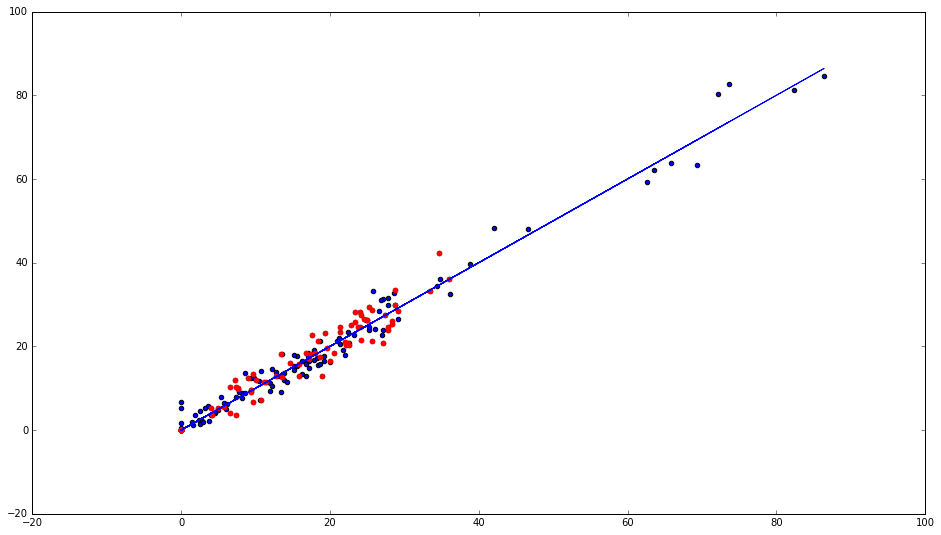

In [39]:
plt.figure(figsize = (16,9))
plt.scatter(full_x_e, full_true_x)
plt.scatter(x_e, true_x, color = 'red')
plt.plot(full_x_e,full_x_e)
plt.show()

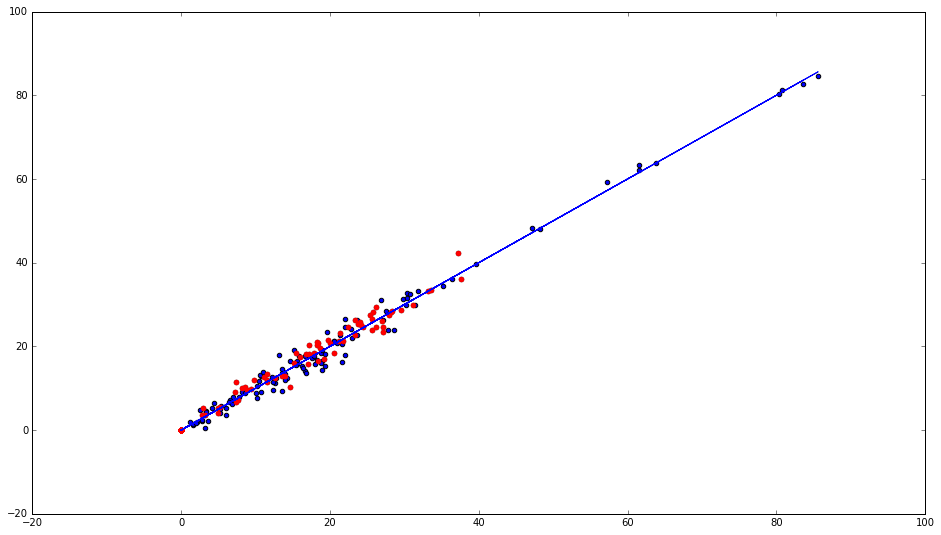

In [40]:
plt.figure(figsize = (16,9))
plt.scatter(full_x_ee, full_true_x)
plt.scatter(x_ee, true_x, color = 'red')
plt.plot(full_x_ee,full_x_ee)
plt.show()

In [41]:
print np.linalg.norm(full_true_x - full_x_ee)
print np.linalg.norm(full_true_x - full_x_e)

25.601562452319197
37.49293266737081


In [42]:
print np.linalg.norm(true_x - x_ee)
print np.linalg.norm(true_x - x_e)

15.256474035634843
24.163609001968236


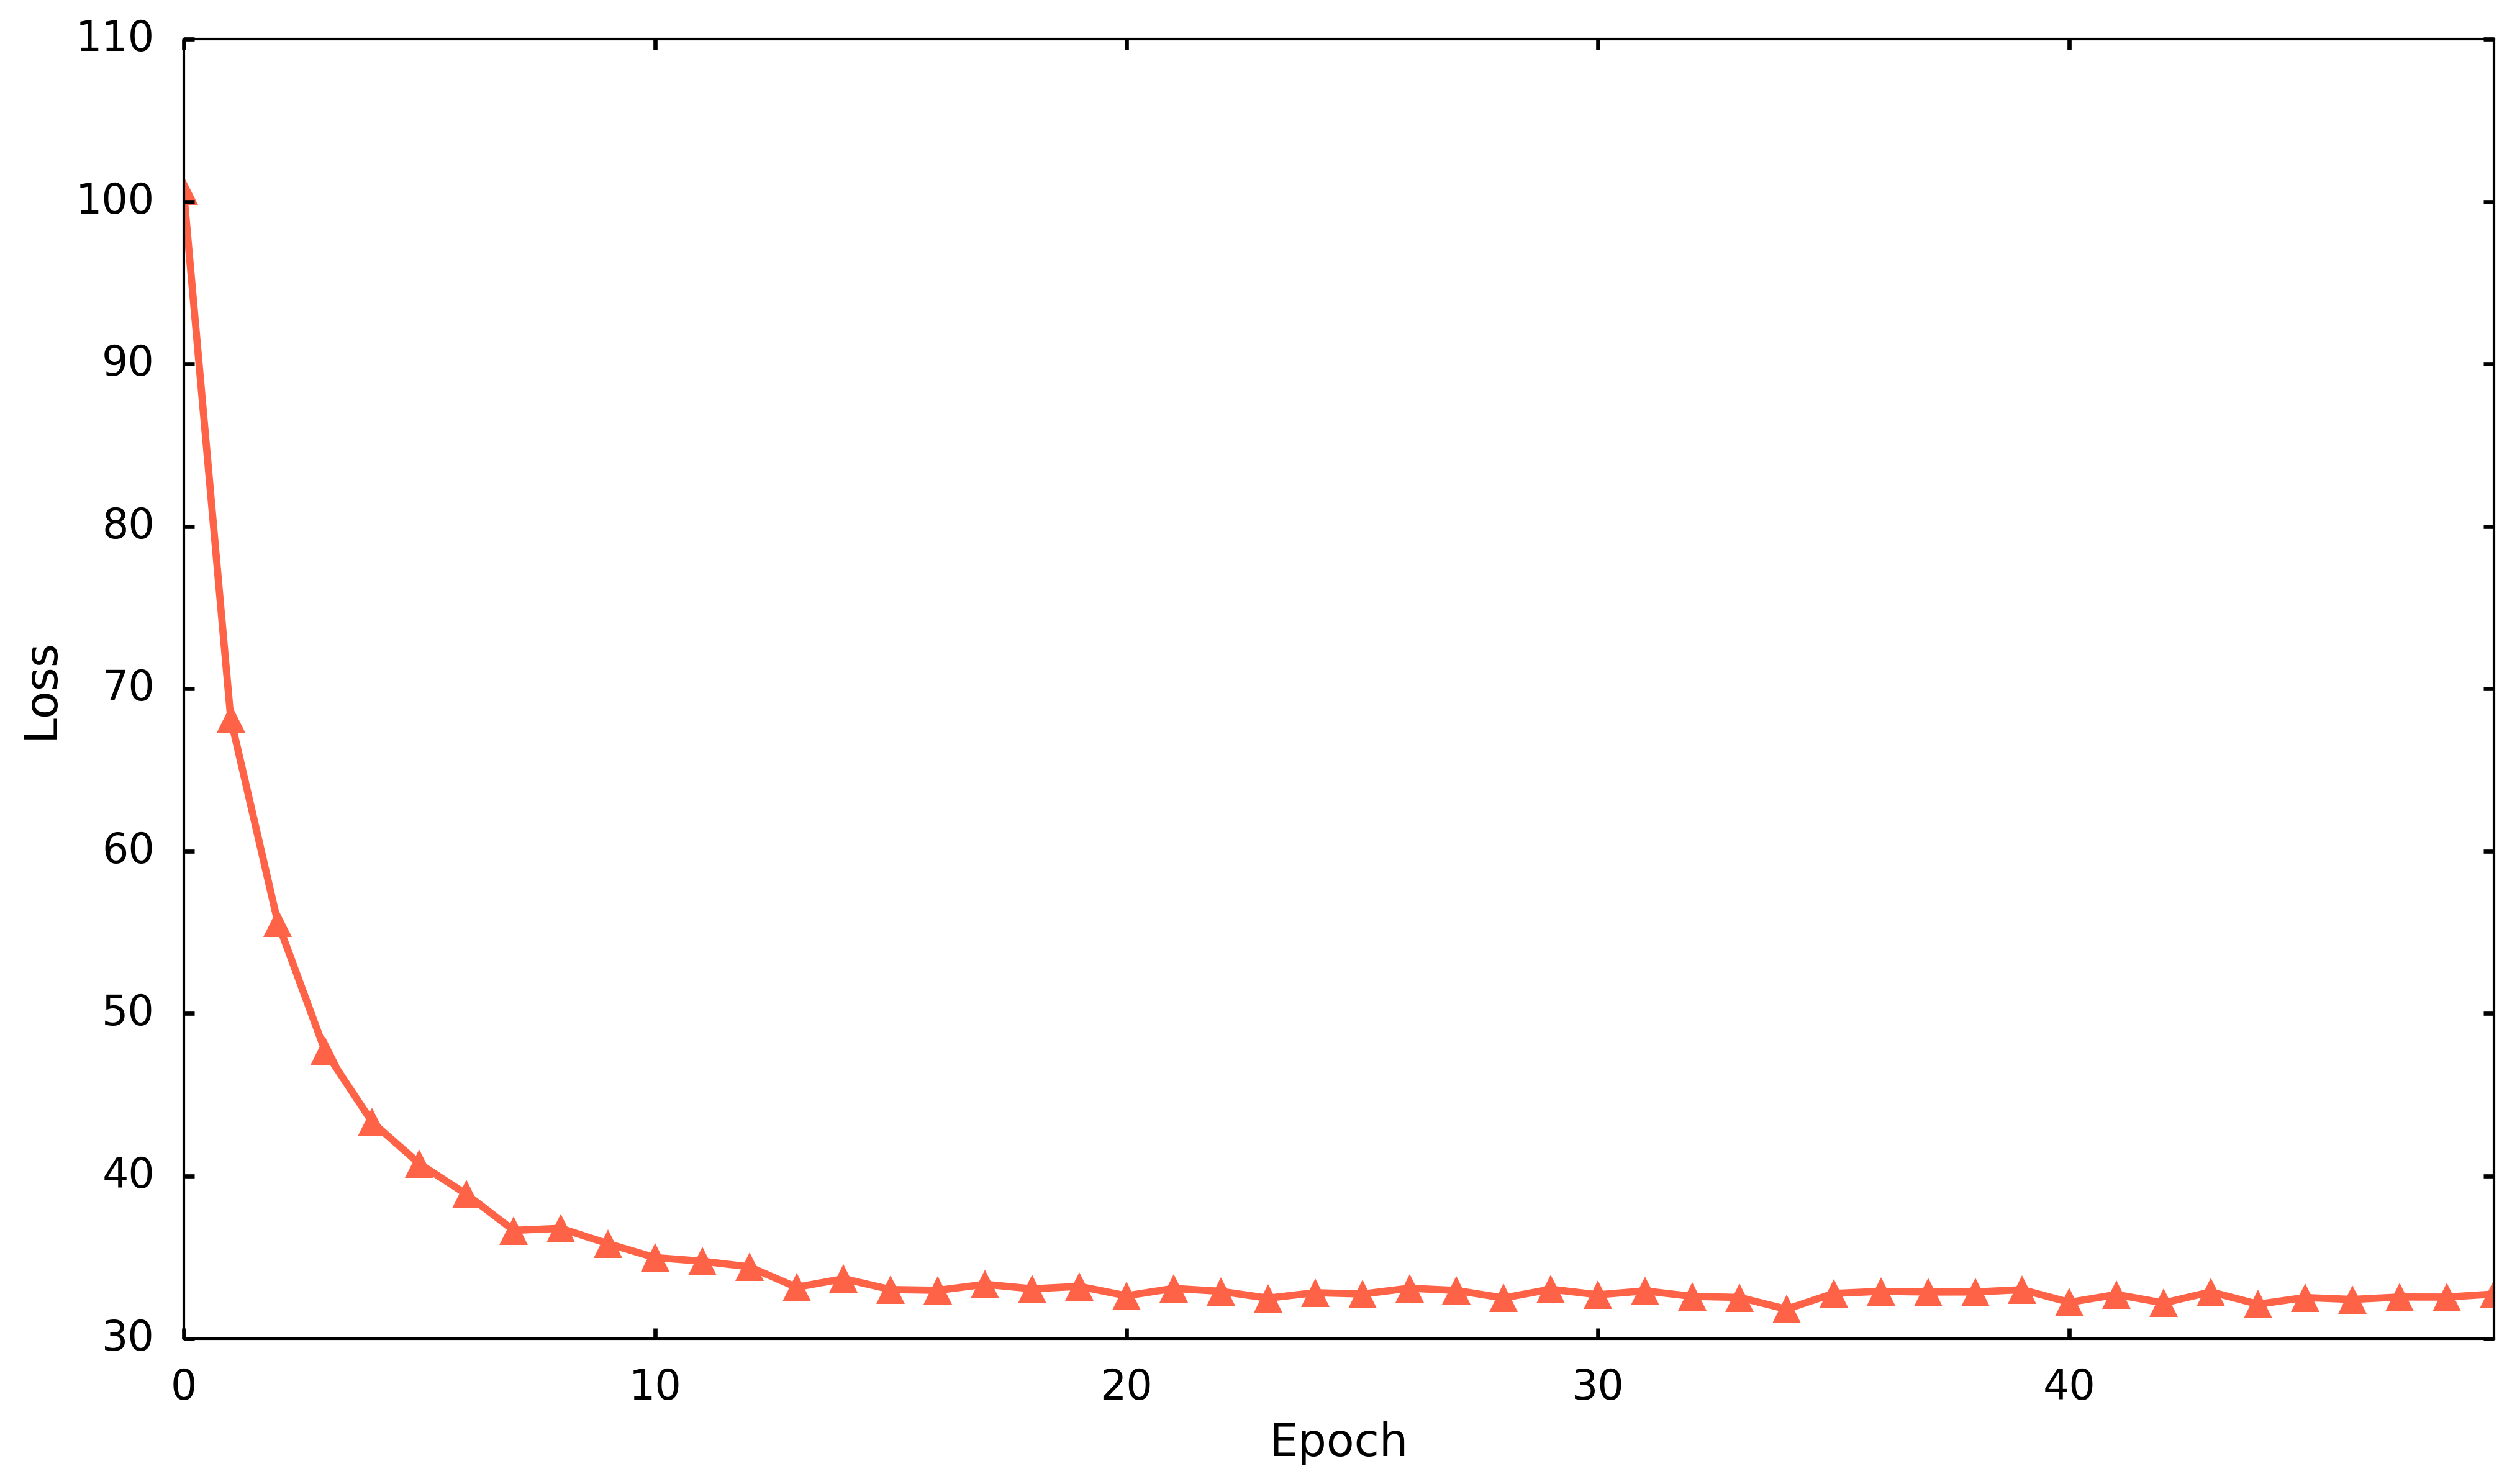

In [25]:
plt.figure(figsize = (16,9), dpi = 300)
plt.plot(range(50), loss_list1[:50], label = 'PDODE', color = 'tomato', marker = '^')
# plt.plot(range(50), loss_list2[:50], label = 'DODE', color = 'teal', linestyle = "--")
# plt.legend()
plt.xlabel("Epoch")
plt.ylabel('Loss')
plt.xlim([0, 49])
plt.show()

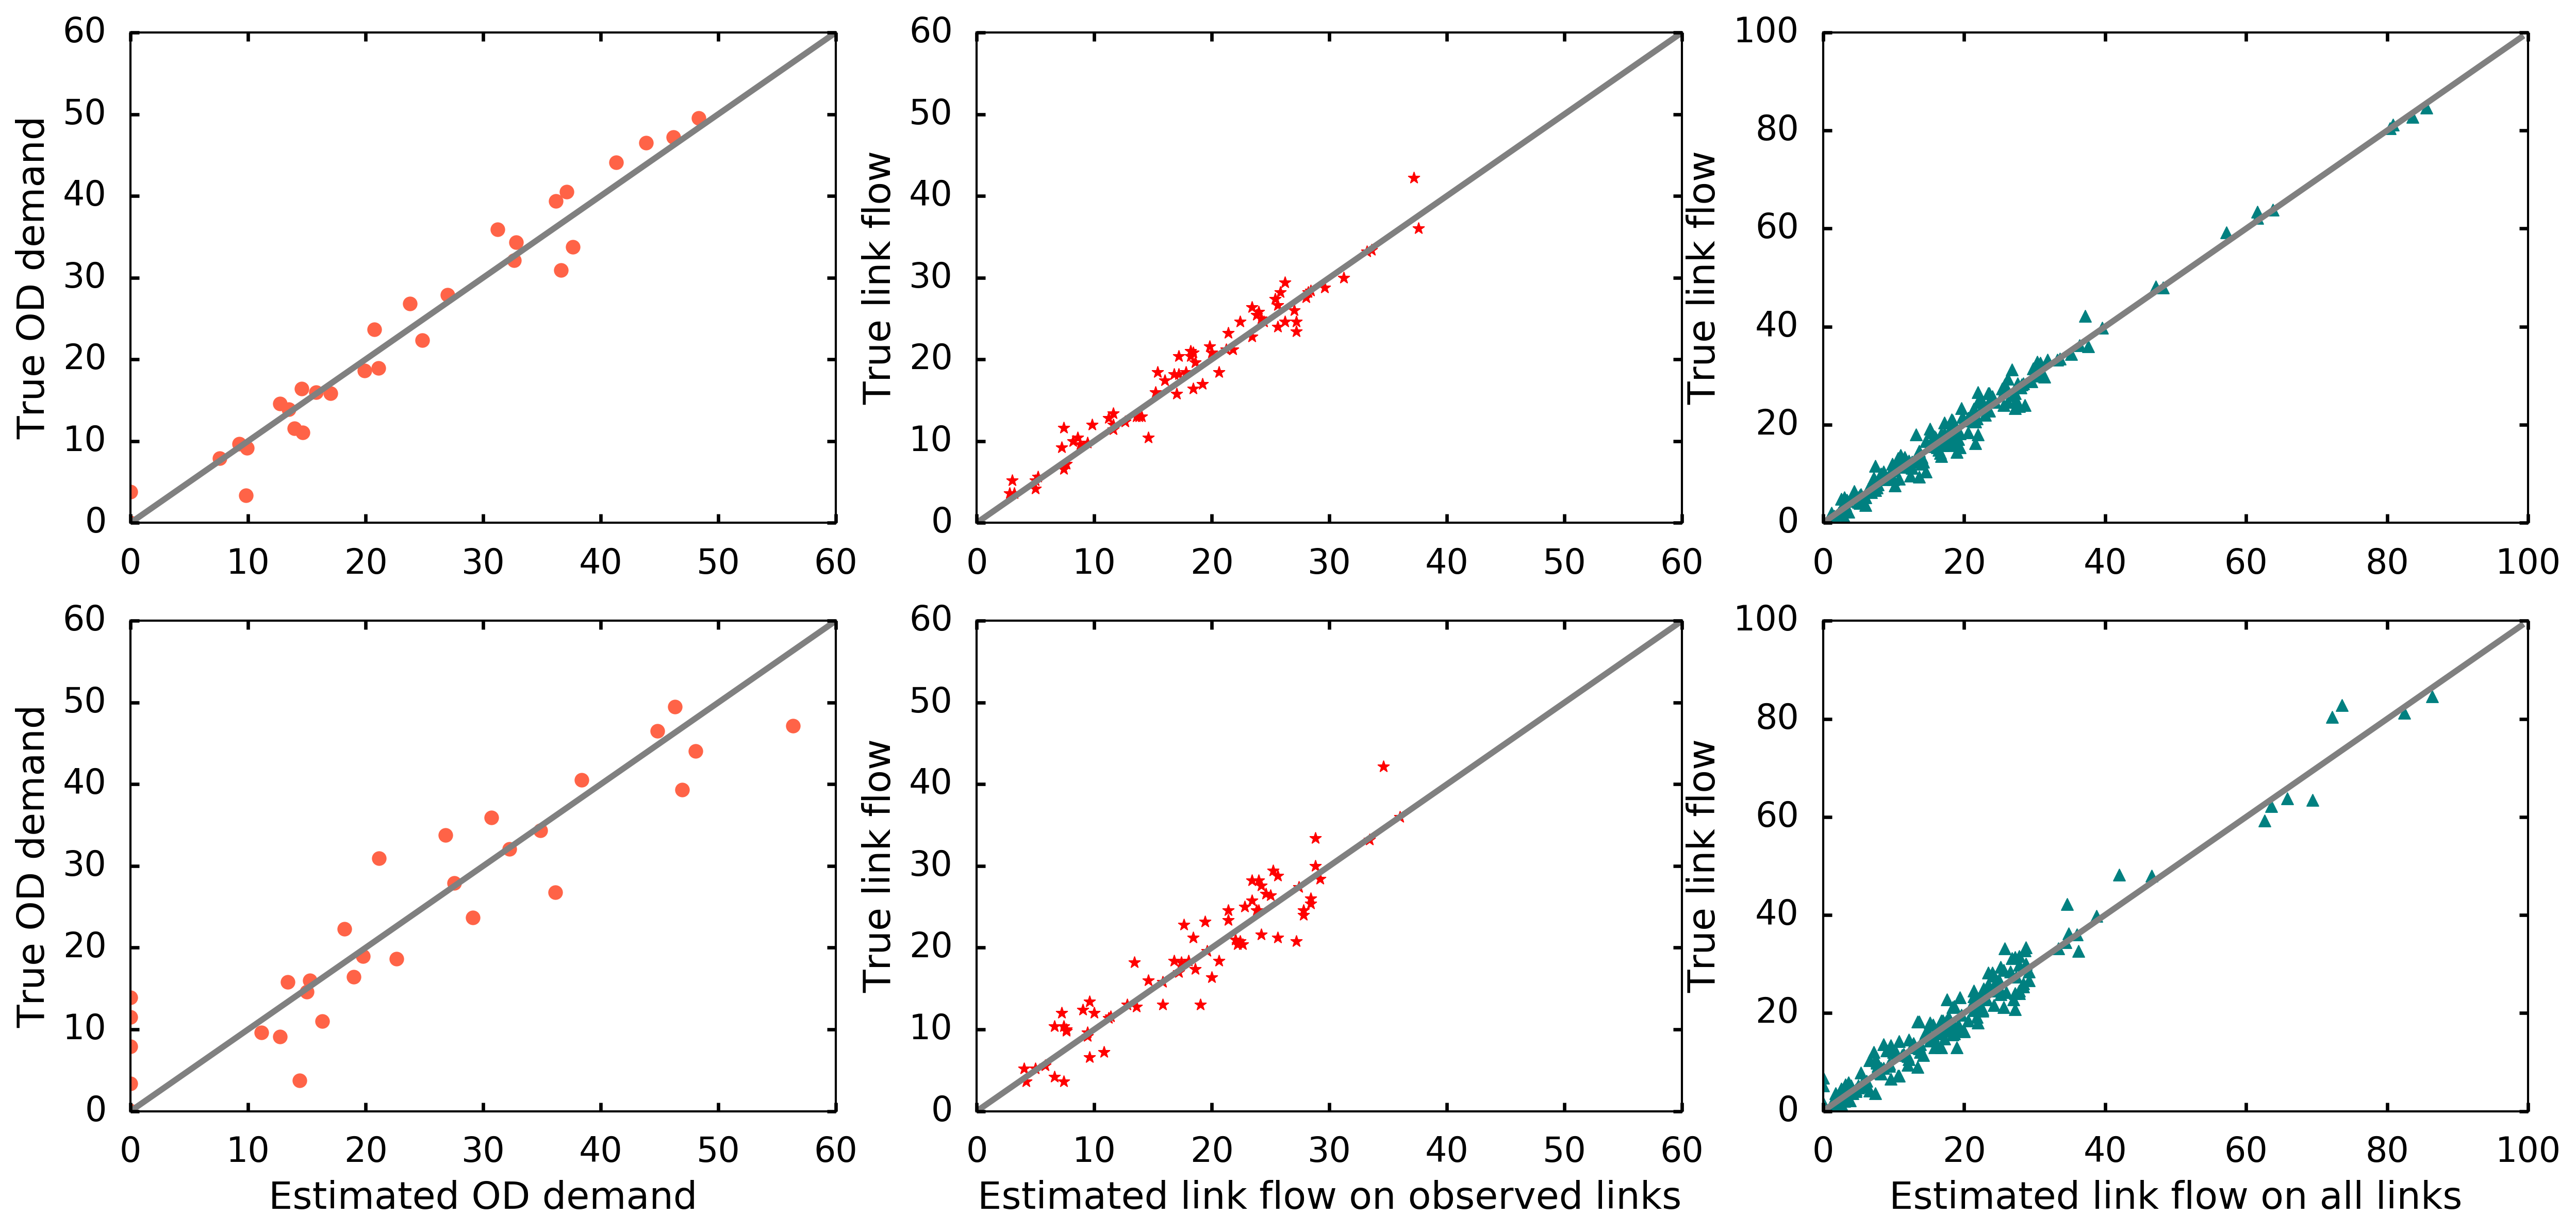

In [66]:
fig, axes = plt.subplots(2,3,  figsize=(20, 9), dpi=300)

axes[0][0].plot(range(100), range(100), color = 'grey')
axes[0][1].plot(range(100), range(100), color = 'grey')
axes[1][0].plot(range(100), range(100), color = 'grey')
axes[1][1].plot(range(100), range(100), color = 'grey')
axes[0][2].plot(range(100), range(100), color = 'grey')
axes[1][2].plot(range(100), range(100), color = 'grey')

axes[0][0].scatter(np.concatenate(q_para.demand_mean_list), np.concatenate(true_q_para.demand_mean_list), 
                   color = 'tomato', s = 40)
axes[0][2].scatter(full_x_ee, full_true_x, color = 'teal', s = 30, marker = "^")
axes[0][1].scatter(x_ee, true_x, color = 'red', s = 30, marker = "*")

axes[1][0].scatter(q_e, np.concatenate(true_q_para.demand_mean_list), color = 'tomato', s = 40)
axes[1][2].scatter(full_x_e, full_true_x, color = 'teal', s = 30, marker = "^")
axes[1][1].scatter(x_e, true_x, color = 'red', s = 30, marker = "*")

axes[0][0].set_xlim([0, 60])
axes[0][0].set_ylim([0, 60])
axes[1][0].set_xlim([0, 60])
axes[1][0].set_ylim([0, 60])

axes[0][2].set_xlim([0, 100])
axes[0][2].set_ylim([0, 100])
axes[1][2].set_xlim([0, 100])
axes[1][2].set_ylim([0, 100])

axes[0][1].set_xlim([0, 60])
axes[0][1].set_ylim([0, 60])
axes[1][1].set_xlim([0, 60])
axes[1][1].set_ylim([0, 60])

axes[1][0].set_xlabel("Estimated OD demand")
axes[0][0].set_ylabel("True OD demand")
axes[1][0].set_ylabel("True OD demand")


axes[1][1].set_xlabel("Estimated link flow on observed links")
axes[0][1].set_ylabel("True link flow")
axes[1][1].set_ylabel("True link flow")

axes[1][2].set_xlabel("Estimated link flow on all links")
axes[0][2].set_ylabel("True link flow")
axes[1][2].set_ylabel("True link flow")

plt.show()

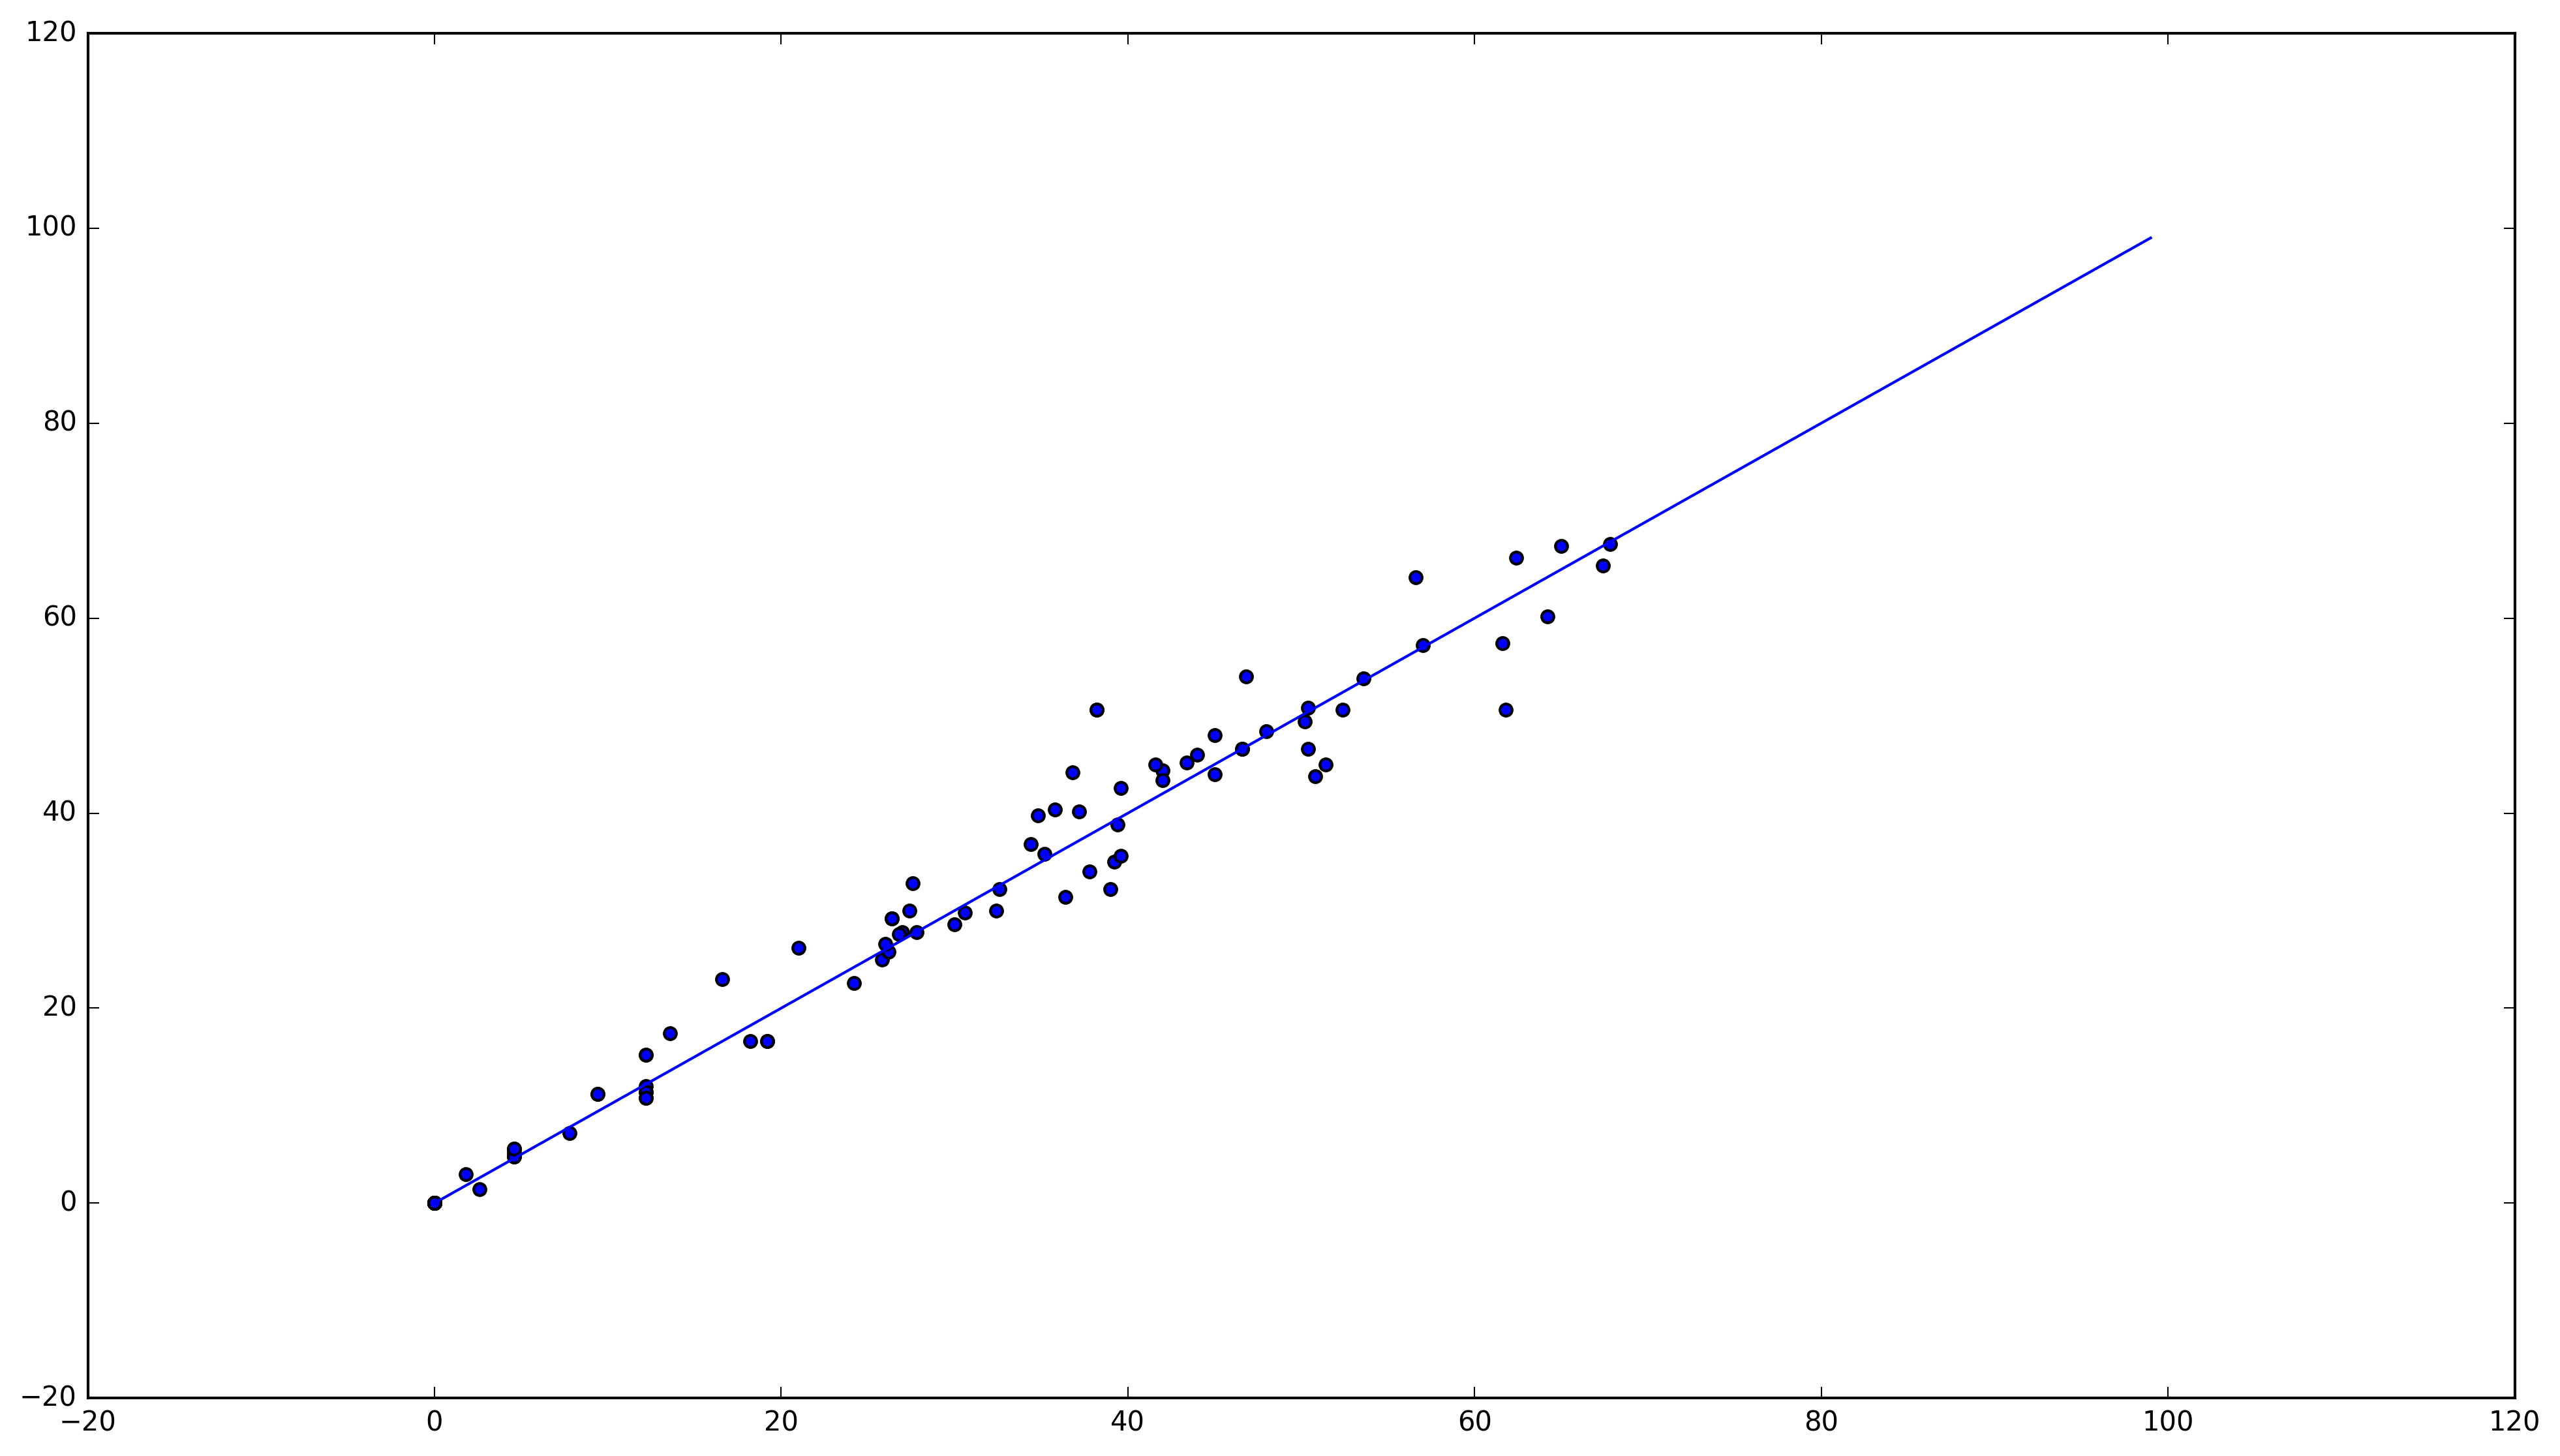

In [27]:
plt.figure(figsize = (16,9), dpi = 300)
plt.scatter(x_e, true_x)
plt.plot(range(100), range(100))
plt.show()

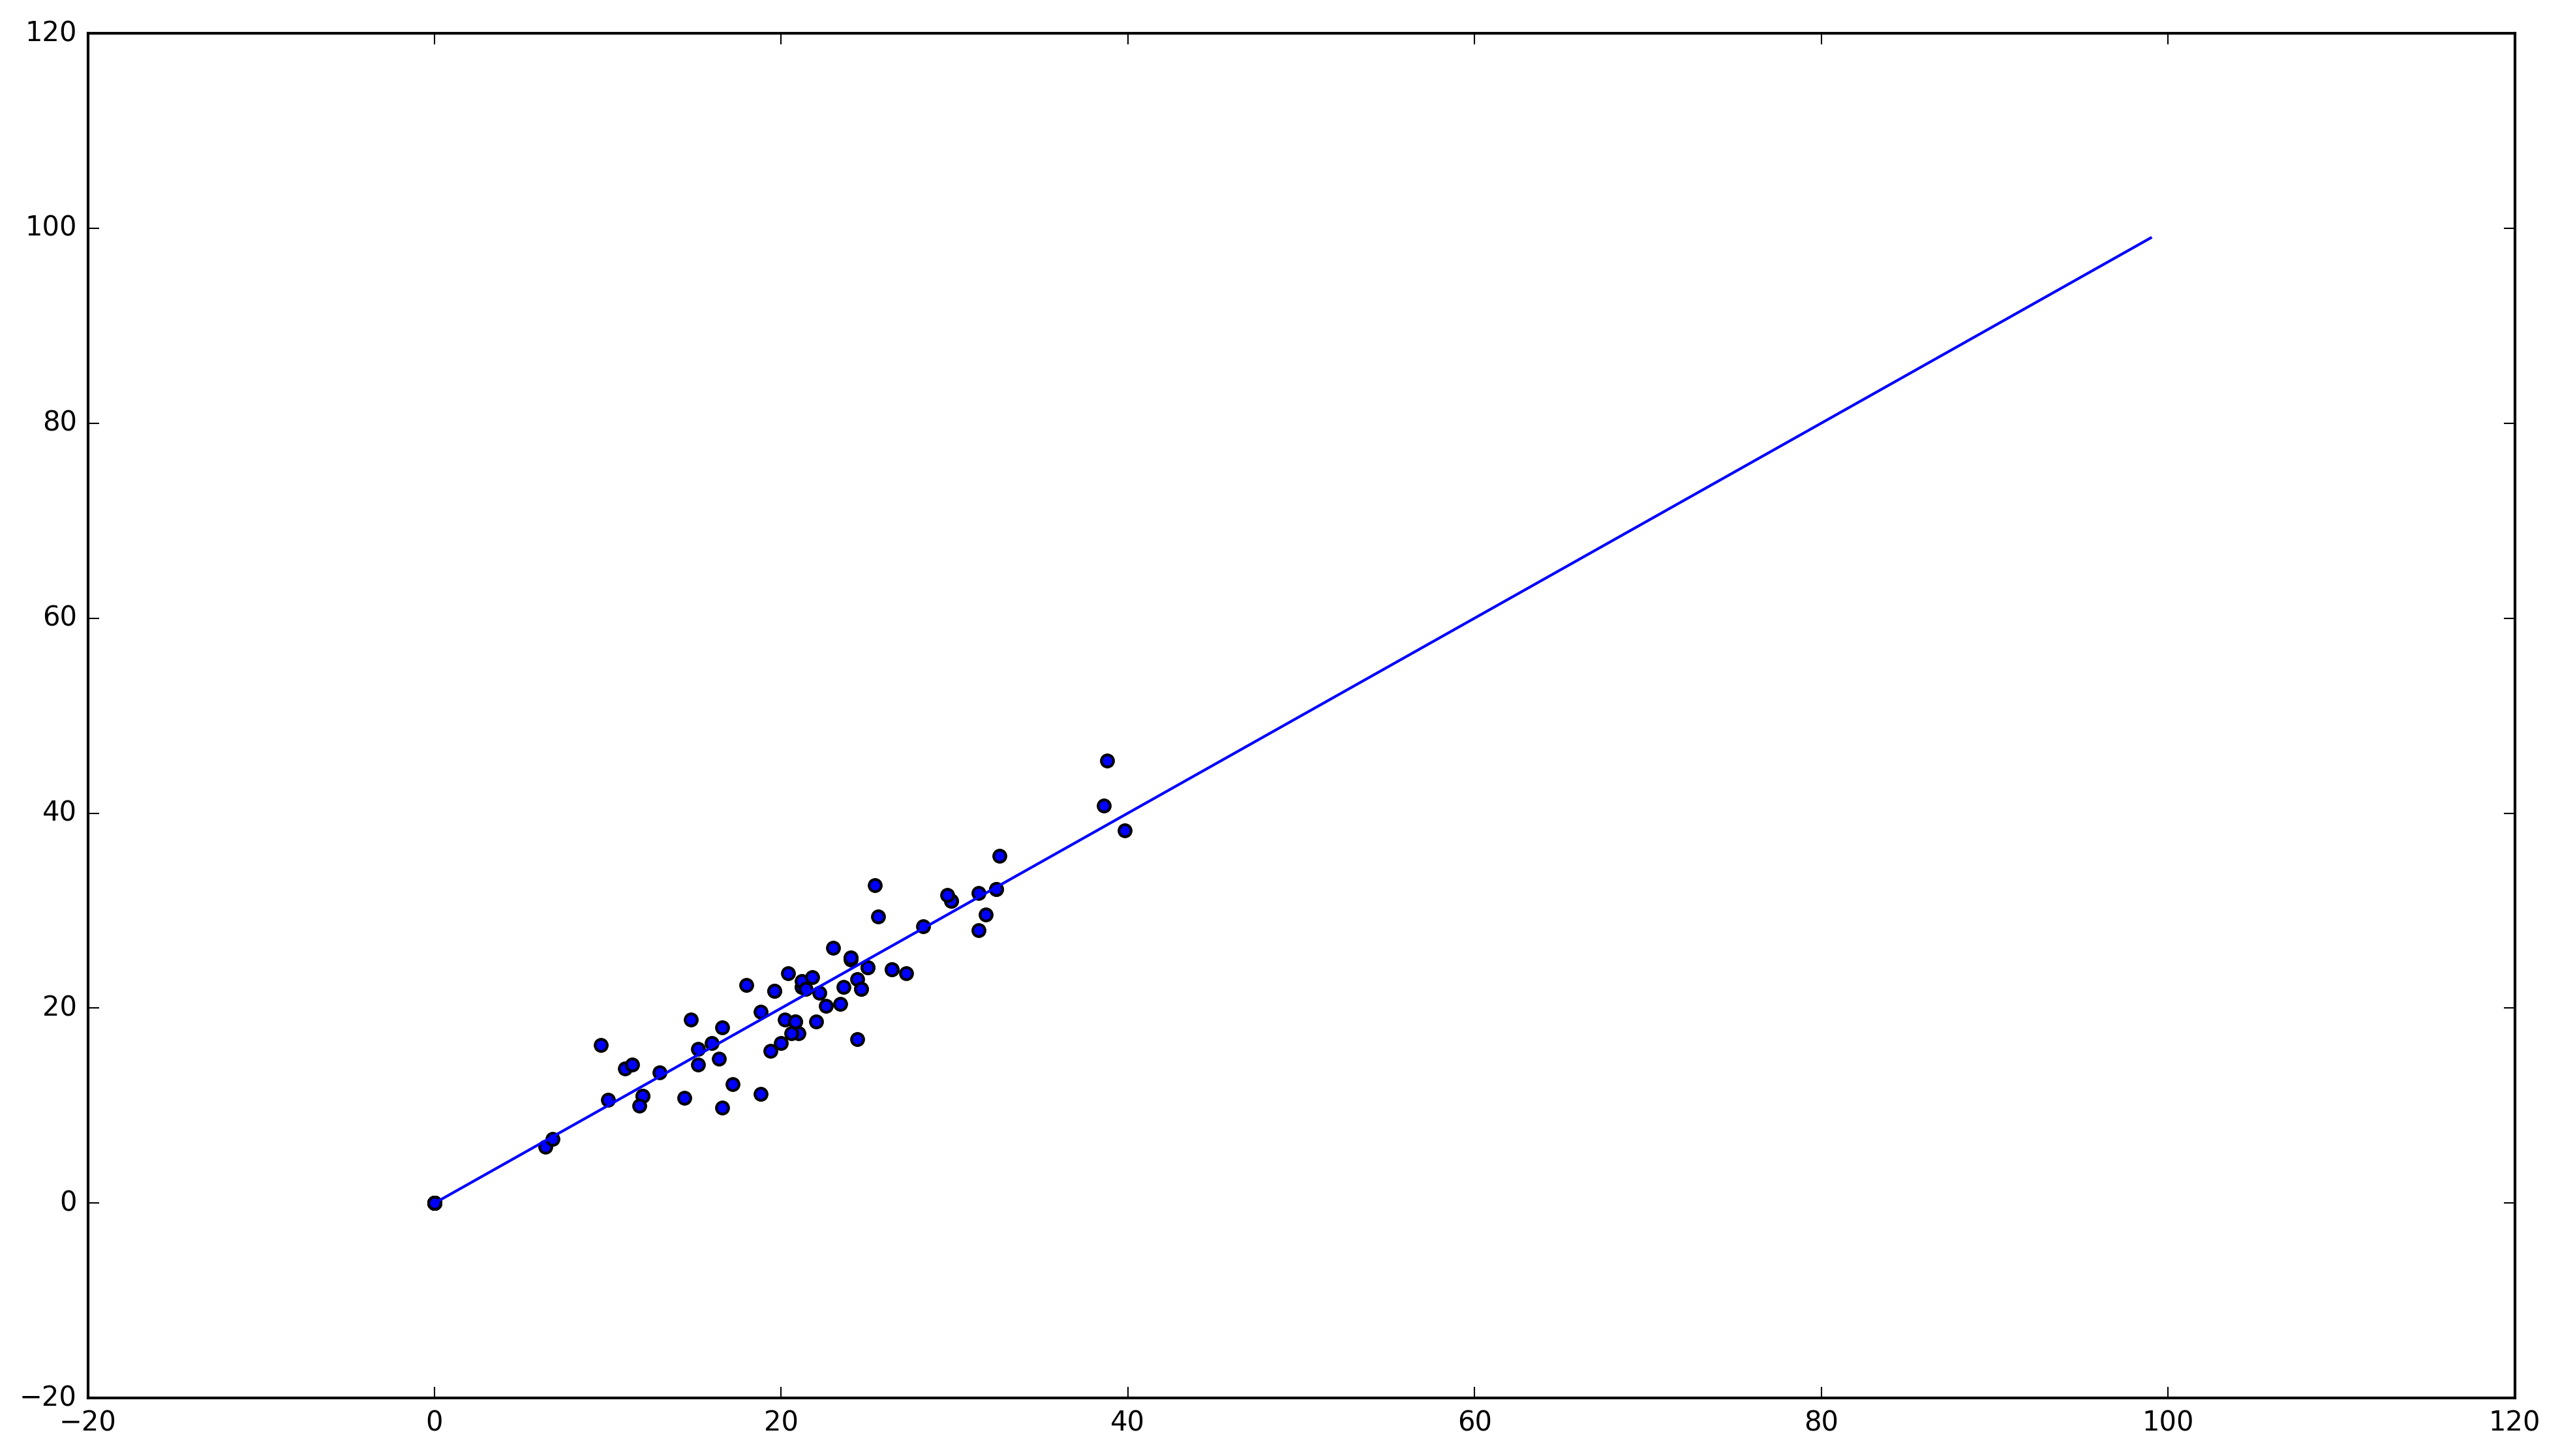

In [59]:
plt.figure(figsize = (16,9), dpi = 300)
plt.scatter(x_ee, true_x)
plt.plot(range(100), range(100))
plt.show()

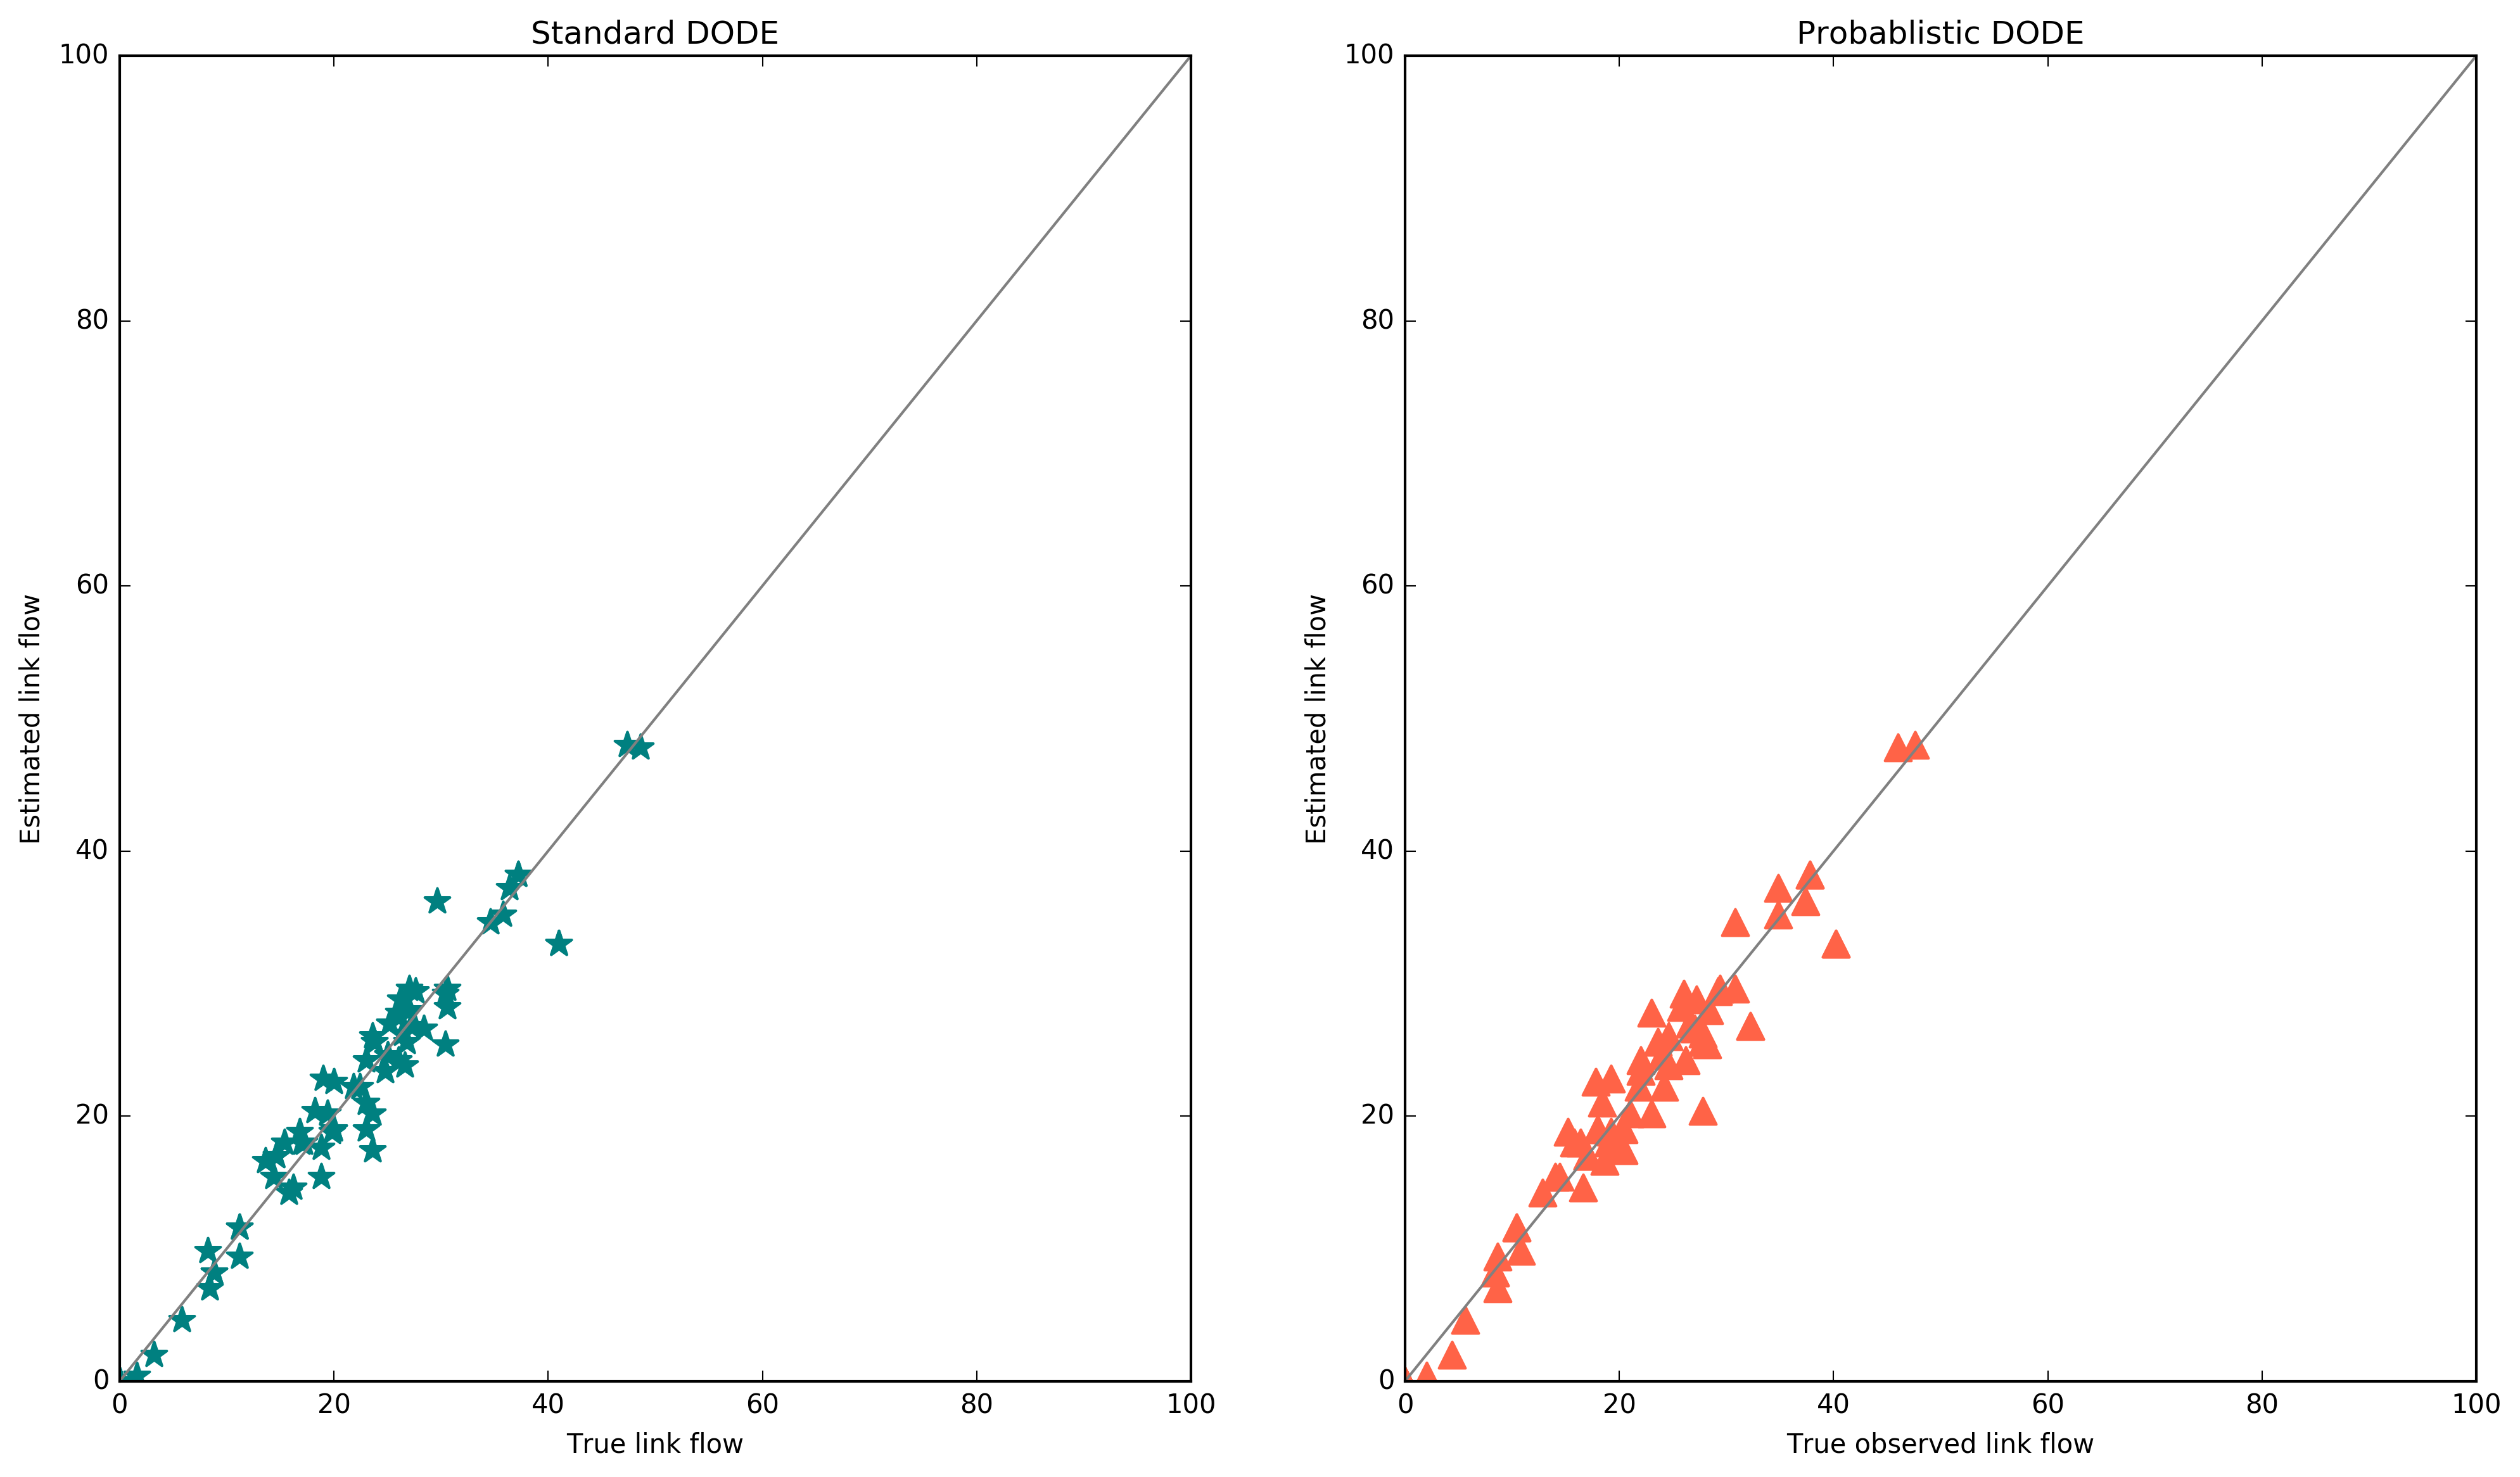

In [33]:
fig, axes = plt.subplots(1,2,  figsize=(16, 9), dpi=300)
# plt.figure(num=None, figsize=(16, 9), dpi=300, facecolor='w', edgecolor='k')
axes[0].scatter(x_e, true_x, label = "Proposed direct solution", color = 'teal', marker = '*', s = 100)
axes[0].plot(range(350), range(350), label = "Convex optimization solution", color = 'gray')
axes[1].scatter(x_ee, true_x, label = "Proposed closed-form method", color = 'tomato', 
                marker = "^", s = 100)
axes[1].plot(range(350), range(350), label = "Convex optimization solution", color = 'gray')
# axes[1].plot(time_list2, gap_rec2, label = "Quadratic solver method", color = 'tomato')
# plt.ylabel("Equilibrium Gap")
# plt.xlabel("Iterations")
# plt.legend()
# plt.xlim([1, 100])
# axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
# axes[0].set_title('Path flow rate (vehs/15-min)')
# axes[1].set_title('Path choice probablity')
axes[0].set_ylabel('Estimated link flow')
axes[0].set_xlabel('True link flow')
axes[1].set_ylabel('Estimated link flow')
axes[1].set_xlabel('True observed link flow')
axes[0].set_xlim([0, 100])
axes[0].set_ylim([0, 100])
axes[1].set_xlim([0, 100])
axes[1].set_ylim([0, 100])

axes[0].set_title('Standard DODE')
axes[1].set_title('Probablistic DODE')

plt.show()

In [34]:
np.linalg.norm(x_ee - true_x)

21.196226079186847

In [35]:
np.linalg.norm(x_e - true_x)

20.81730049742282

In [89]:
from sklearn.metrics import r2_score
from scipy import stats
def r2(predictions, targets):
    y_bar = np.mean(targets)
    # diff = np.minimum(np.abs(predictions - targets), targets)
    diff = predictions - targets
    ss_e = np.sum(diff ** 2)
    ss_t = np.sum((targets) ** 2)
    return 1 - ss_e / ss_t

def rsquared(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return r_value**2

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def rmsn(predictions, targets):
    return np.sqrt(np.sum((predictions - targets) ** 2) * len(predictions)) / np.sum(targets)

In [94]:
rsquared(x_ee, true_x)

0.9857612654468736

In [95]:
rsquared(x_e, true_x)

0.9630195607553345

In [96]:
rsquared(q_e, true_q)

0.8566989443554502

In [97]:
rsquared(q_ee, true_q)

0.9632464846762037

In [98]:
rsquared(full_x_ee, full_true_x)

0.9899410585347843

In [99]:
rsquared(full_x_e, full_true_x)

0.9785819096899961